# **DATA603 Project - Twitter Sentiment Analysis for Predicting Stock Market Trends**
### **Team**
1. Akhilteja Jampani
2. Chaturya Gajula​
3. Santosh Kumar Velgapuri​ 
4. Siddhidhatri Rohith Reddy Jaggari

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=c56cc8b2f8eba08f9b6bd3c46847ab0fbb72e347fd61f109ec51518f2e6eb679
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Twitter Sentiment Analysis") \
    .getOrCreate()

df_tweet = spark.read.format("csv").option("header", True).load("/content/drive/MyDrive/archive/tweet_data.csv")
df_company_tweets = spark.read.format("csv").option("header", True).load("/content/drive/MyDrive/archive/Company_Tweet.csv")
df_company = spark.read.format("csv").option("header", True).load("/content/drive/MyDrive/archive/Company.csv")


In [5]:
from pyspark.sql.functions import regexp_replace

df_tweet = df_tweet.withColumn("tweet", regexp_replace("body", r'^RT[\s]+', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'https?:\/\/.*[\r\n]*', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'#', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'[0-9]', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'@[A-Za-z0-9]+', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'[^\w\s]', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'[$%^*()_+|~=`{}\[\]:";\<>\/]', ''))
df_tweet = df_tweet.withColumn("tweet", regexp_replace("tweet", r'\s+', ' '))
# df_tweet = df_tweet.withColumn("tweet", df_tweet["tweet"].trim().lower())
from pyspark.sql.functions import lower, trim
df_tweet = df_tweet.withColumn("tweet", lower(trim(df_tweet["tweet"])))

In [6]:
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=420a7b744a557fdfd49158c83735694e06511945ff5c8010685370a6e9226c17
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [7]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StringType
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vanderSentimentAnalyzer = SentimentIntensityAnalyzer()

afinn = Afinn()
vanderSentimentAnalyzer = SentimentIntensityAnalyzer()

def afinn_score(tweet):
    return afinn.score(tweet)

def vander_score(tweet):
    vs = vanderSentimentAnalyzer.polarity_scores(tweet)
    score = vs['compound']
    return score

def vander_sentiment(score):
    if (score >= 0.05): 
        return "Positive"
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    elif (score <= -0.05):    
        return "Negative"
    return score

afinn_udf = udf(afinn_score, DoubleType())
vander_score_udf = udf(vander_score, DoubleType())
vander_sentiment_udf = udf(vander_sentiment, StringType())

df_tweet = df_tweet.withColumn("afinn_score", afinn_udf(df_tweet["tweet"]))
df_tweet = df_tweet.withColumn("vander_score", vander_score_udf(df_tweet["body"]))
df_tweet = df_tweet.withColumn("vander_sentiment", vander_sentiment_udf(df_tweet["vander_score"]))
# print(df_tweet.show(50))

In [9]:
print(df_tweet.show(5))

+------------------+-------------+-------------+--------------------+-----------+-----------+--------+------------+-------------------+--------------------+-----------+------------+----------------+
|          tweet_id|ticker_symbol|       writer|                body|comment_num|retweet_num|like_num|company_name|         tweet_date|               tweet|afinn_score|vander_score|vander_sentiment|
+------------------+-------------+-------------+--------------------+-----------+-----------+--------+------------+-------------------+--------------------+-----------+------------+----------------+
|550803612197457920|         AAPL|   SentiQuant|#TOPTICKERTWEETS ...|          0|          0|       1|       apple|2015-01-01 23:59:49|toptickertweets a...|        0.0|         0.0|         Neutral|
|550803610825928706|         AAPL|   SentiQuant|#SENTISHIFTUP $K ...|          0|          0|       1|       apple|2015-01-01 23:59:48|sentishiftup k fb...|        2.0|         0.0|         Neutral|
|5508

In [10]:
from pyspark.sql.functions import col
# Add a new column "total_eng" that represents the total engagement
df_tweet = df_tweet.withColumn("total_engagements", col("comment_num") + col("retweet_num") + col("like_num"))

# Show the resulting dataframe
df_tweet.show(5)

+------------------+-------------+-------------+--------------------+-----------+-----------+--------+------------+-------------------+--------------------+-----------+------------+----------------+-----------------+
|          tweet_id|ticker_symbol|       writer|                body|comment_num|retweet_num|like_num|company_name|         tweet_date|               tweet|afinn_score|vander_score|vander_sentiment|total_engagements|
+------------------+-------------+-------------+--------------------+-----------+-----------+--------+------------+-------------------+--------------------+-----------+------------+----------------+-----------------+
|550803612197457920|         AAPL|   SentiQuant|#TOPTICKERTWEETS ...|          0|          0|       1|       apple|2015-01-01 23:59:49|toptickertweets a...|        0.0|         0.0|         Neutral|              1.0|
|550803610825928706|         AAPL|   SentiQuant|#SENTISHIFTUP $K ...|          0|          0|       1|       apple|2015-01-01 23:59:

In [11]:
df_tweet.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- ticker_symbol: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- body: string (nullable = true)
 |-- comment_num: string (nullable = true)
 |-- retweet_num: string (nullable = true)
 |-- like_num: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- tweet_date: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- afinn_score: double (nullable = true)
 |-- vander_score: double (nullable = true)
 |-- vander_sentiment: string (nullable = true)
 |-- total_engagements: double (nullable = true)



In [13]:
df_tweet = df_tweet.drop("comment_num", "retweet_num", "like_num","writer","body")
df_tweet.show(5)

+------------------+-------------+------------+-------------------+--------------------+-----------+------------+----------------+-----------------+
|          tweet_id|ticker_symbol|company_name|         tweet_date|               tweet|afinn_score|vander_score|vander_sentiment|total_engagements|
+------------------+-------------+------------+-------------------+--------------------+-----------+------------+----------------+-----------------+
|550803612197457920|         AAPL|       apple|2015-01-01 23:59:49|toptickertweets a...|        0.0|         0.0|         Neutral|              1.0|
|550803610825928706|         AAPL|       apple|2015-01-01 23:59:48|sentishiftup k fb...|        2.0|         0.0|         Neutral|              1.0|
|550803225113157632|         AAPL|       apple|2015-01-01 23:58:16|rumor roundup wha...|        0.0|         0.0|         Neutral|              0.0|
|550802957370159104|         AAPL|       apple|2015-01-01 23:57:13|an aapl store lin...|        3.0|      

# **Apple**

In [14]:
from pyspark.sql.functions import col
df_tweet_aapl= df_tweet.filter((col("ticker_symbol") == "AAPL"))

In [15]:
df_tweet_aapl=df_tweet_aapl.drop("tweet_id","company_name","tweet","afinn_score","vander_score","total_engagements")
df_tweet_aapl.show(5)

+-------------+-------------------+----------------+
|ticker_symbol|         tweet_date|vander_sentiment|
+-------------+-------------------+----------------+
|         AAPL|2015-01-01 23:59:49|         Neutral|
|         AAPL|2015-01-01 23:59:48|         Neutral|
|         AAPL|2015-01-01 23:58:16|         Neutral|
|         AAPL|2015-01-01 23:57:13|        Positive|
|         AAPL|2015-01-01 23:56:48|        Positive|
+-------------+-------------------+----------------+
only showing top 5 rows



In [16]:
pandas_df = df_tweet_aapl.toPandas()

In [17]:
import pandas as pd
import datetime
pandas_df['tweet_date'] = pd.to_datetime(pandas_df['tweet_date'], errors='coerce')
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425013 entries, 0 to 1425012
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   ticker_symbol     1425013 non-null  object        
 1   tweet_date        1415665 non-null  datetime64[ns]
 2   vander_sentiment  1425013 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 32.6+ MB


In [18]:
pandas_df["tweet_date"] = pandas_df["tweet_date"].dt.date

In [19]:
# Filter the data for apple company
df_aapl=pandas_df[pandas_df["ticker_symbol"]=="AAPL"]
df_aapl

,ticker_symbol,tweet_date,vander_sentiment
0,AAPL,2015-01-01,Neutral
1,AAPL,2015-01-01,Neutral
2,AAPL,2015-01-01,Neutral
3,AAPL,2015-01-01,Positive
4,AAPL,2015-01-01,Positive
...,...,...,...
1425008,AAPL,2019-12-31,Positive
1425009,AAPL,2019-12-31,Positive
1425010,AAPL,2019-12-31,Negative
1425011,AAPL,2019-12-31,Neutral


In [20]:
# Finding how many negative,positive and neutral tweets are present each day
df_aapl12=df_aapl.groupby(["tweet_date", "vander_sentiment"]).size().reset_index().rename(columns={0: "count"})
df_aapl12

,tweet_date,vander_sentiment,count
0,2015-01-01,Negative,42
1,2015-01-01,Neutral,134
2,2015-01-01,Positive,117
3,2015-01-02,Negative,158
4,2015-01-02,Neutral,396
...,...,...,...
5451,2019-12-30,Neutral,302
5452,2019-12-30,Positive,322
5453,2019-12-31,Negative,93
5454,2019-12-31,Neutral,304


In [21]:
new_df_aapl = df_aapl12.pivot_table(index='tweet_date', columns='vander_sentiment', values='count').reset_index().rename_axis(None, axis=1).fillna(0)
new_df_aapl.columns = ['date', 'negative_count', 'neutral_count', 'positive_count']

In [22]:
new_df_aapl

,date,negative_count,neutral_count,positive_count
0,2015-01-01,42.0,134.0,117.0
1,2015-01-02,158.0,396.0,297.0
2,2015-01-03,34.0,134.0,178.0
3,2015-01-04,44.0,159.0,201.0
4,2015-01-05,210.0,469.0,461.0
...,...,...,...,...
1814,2019-12-27,62.0,143.0,168.0
1815,2019-12-28,28.0,97.0,83.0
1816,2019-12-29,26.0,79.0,83.0
1817,2019-12-30,102.0,302.0,322.0


In [23]:
new_df_aapl['date'] = pd.to_datetime(new_df_aapl['date'])
new_df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1819 non-null   datetime64[ns]
 1   negative_count  1819 non-null   float64       
 2   neutral_count   1819 non-null   float64       
 3   positive_count  1819 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.0 KB


In [24]:
df1_aapl=pd.read_csv("/content/drive/MyDrive/archive/AAPL_ALL.csv")

In [25]:
df1_aapl.head(5)

,Date,Open,High,Low,Close,Volume
0,12/31/2019,72.48,73.42,72.38,73.41,"100,990,524"
1,12/30/2019,72.37,73.17,71.31,72.88,"144,238,436"
2,12/27/2019,72.78,73.49,72.03,72.45,"146,371,764"
3,12/26/2019,71.21,72.50,71.18,72.48,"93,336,000"
4,12/24/2019,71.17,71.22,70.73,71.07,"48,478,840"


In [26]:
df1_aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1263 non-null   object 
 1   Open    1263 non-null   float64
 2   High    1263 non-null   float64
 3   Low     1263 non-null   float64
 4   Close   1263 non-null   float64
 5   Volume  1263 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.3+ KB


In [27]:
# Converting to datetime
df1_aapl['Date'] = pd.to_datetime(df1_aapl['Date'])
df1_aapl.head(5)

,Date,Open,High,Low,Close,Volume
0,2019-12-31,72.48,73.42,72.38,73.41,"100,990,524"
1,2019-12-30,72.37,73.17,71.31,72.88,"144,238,436"
2,2019-12-27,72.78,73.49,72.03,72.45,"146,371,764"
3,2019-12-26,71.21,72.50,71.18,72.48,"93,336,000"
4,2019-12-24,71.17,71.22,70.73,71.07,"48,478,840"


In [28]:
# merging data frames
df2_aapl = pd.merge(new_df_aapl, df1_aapl.rename(columns={'Date': 'date'}), on='date', how='inner')
df2_aapl.head()

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,158.0,396.0,297.0,27.85,27.86,26.84,27.33,"212,818,532"
1,2015-01-05,210.0,469.0,461.0,27.07,27.16,26.35,26.56,"257,141,952"
2,2015-01-06,167.0,520.0,496.0,26.64,26.86,26.16,26.57,"263,188,468"
3,2015-01-07,170.0,475.0,446.0,26.80,27.05,26.67,26.94,"160,423,720"
4,2015-01-08,163.0,696.0,620.0,27.31,28.04,27.18,27.97,"237,458,204"


In [29]:
df2_aapl = df2_aapl.sort_values(by="date")
df2_aapl.head(10)

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,158.0,396.0,297.0,27.85,27.86,26.84,27.33,"212,818,532"
1,2015-01-05,210.0,469.0,461.0,27.07,27.16,26.35,26.56,"257,141,952"
2,2015-01-06,167.0,520.0,496.0,26.64,26.86,26.16,26.57,"263,188,468"
3,2015-01-07,170.0,475.0,446.0,26.80,27.05,26.67,26.94,"160,423,720"
4,2015-01-08,163.0,696.0,620.0,27.31,28.04,27.18,27.97,"237,458,204"
5,2015-01-09,169.0,519.0,426.0,28.17,28.31,27.55,28.00,"214,798,108"
6,2015-01-12,138.0,433.0,366.0,28.15,28.16,27.20,27.31,"198,603,172"
7,2015-01-13,185.0,609.0,569.0,27.86,28.20,27.23,27.56,"268,367,720"
8,2015-01-14,159.0,435.0,347.0,27.26,27.62,27.13,27.45,"195,826,376"
9,2015-01-15,210.0,563.0,353.0,27.50,27.52,26.67,26.71,"240,056,000"


In [30]:
df3_aapl=df2_aapl[["date","negative_count","neutral_count","positive_count","Close"]]
df3_aapl["prev_close"] = df2_aapl["Close"].shift(1)
df3_aapl = df3_aapl.drop(0)

<ipython-input-30-4fbb9838c2e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_aapl["prev_close"] = df2_aapl["Close"].shift(1)


In [31]:
df3_aapl.head()

,date,negative_count,neutral_count,positive_count,Close,prev_close
1,2015-01-05,210.0,469.0,461.0,26.56,27.33
2,2015-01-06,167.0,520.0,496.0,26.57,26.56
3,2015-01-07,170.0,475.0,446.0,26.94,26.57
4,2015-01-08,163.0,696.0,620.0,27.97,26.94
5,2015-01-09,169.0,519.0,426.0,28.00,27.97


## **Tableau Visualization for apple**

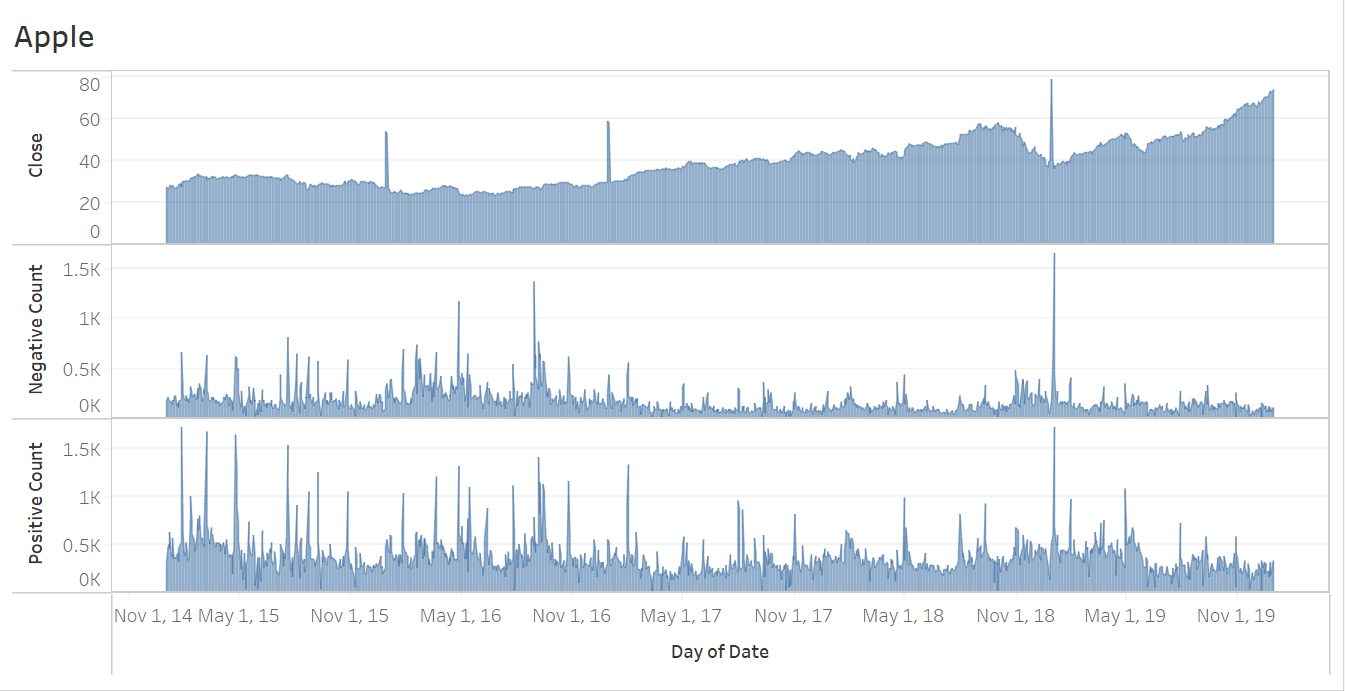

In [32]:
sdf_aapl = spark.createDataFrame(df3_aapl)

In [33]:
sdf_aapl.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|
+-------------------+--------------+-------------+--------------+-----+----------+
|2015-01-05 00:00:00|         210.0|        469.0|         461.0|26.56|     27.33|
|2015-01-06 00:00:00|         167.0|        520.0|         496.0|26.57|     26.56|
|2015-01-07 00:00:00|         170.0|        475.0|         446.0|26.94|     26.57|
|2015-01-08 00:00:00|         163.0|        696.0|         620.0|27.97|     26.94|
|2015-01-09 00:00:00|         169.0|        519.0|         426.0| 28.0|     27.97|
+-------------------+--------------+-------------+--------------+-----+----------+
only showing top 5 rows



In [34]:
# Import required modules
from pyspark.ml.feature import VectorAssembler

# Define the feature column names
feature_cols = ['negative_count','neutral_count','positive_count','prev_close']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform the data using the VectorAssembler
data_aapl = assembler.transform(sdf_aapl)
data_aapl = data_aapl.na.drop()

# Split the data into training and test sets
train_data_aapl = data_aapl.limit(int(0.80 * data_aapl.count()))
test_data_aapl = data_aapl.subtract(train_data_aapl)


In [35]:
from pyspark.ml.feature import StandardScaler

# Define the scaler and fit it on the training data
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(train_data_aapl)

# Apply the scaler on both training and test data
train_data_aapl = scaler_model.transform(train_data_aapl)
test_data_aapl = scaler_model.transform(test_data_aapl)


In [36]:
train_data_aapl.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|            features|     scaled_features|
+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|2015-01-05 00:00:00|         210.0|        469.0|         461.0|26.56|     27.33|[210.0,469.0,461....|[0.28314370911677...|
|2015-01-06 00:00:00|         167.0|        520.0|         496.0|26.57|     26.56|[167.0,520.0,496....|[-0.0465523069228...|
|2015-01-07 00:00:00|         170.0|        475.0|         446.0|26.94|     26.57|[170.0,475.0,446....|[-0.0235502592921...|
|2015-01-08 00:00:00|         163.0|        696.0|         620.0|27.97|     26.94|[163.0,696.0,620....|[-0.0772217037637...|
|2015-01-09 00:00:00|         169.0|        519.0|         426.0| 28.0|     27.97|[169.0,519.0,426....|[-0.0312176085024...|


In [37]:
# Import required modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

# Train linear regression model on the training data
lr = LinearRegression(featuresCol='scaled_features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data_aapl)

# Train decision tree regression model on the training data
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='Close', maxDepth=5, minInstancesPerNode=20)
dt_model = dt.fit(train_data_aapl)

# Train gradient boosted tree regression model on the training data
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='Close', maxIter=10, maxDepth=5, minInstancesPerNode=20)
gbt_model = gbt.fit(train_data_aapl)

# Make predictions on the train data using all models
train_lr_predictions_aapl = lr_model.transform(train_data_aapl)
train_dt_predictions_aapl = dt_model.transform(train_data_aapl)
train_gbt_predictions_aapl = gbt_model.transform(train_data_aapl)

# Make predictions on the test data using all models
test_lr_predictions_aapl = lr_model.transform(test_data_aapl)
test_dt_predictions_aapl = dt_model.transform(test_data_aapl)
test_gbt_predictions_aapl = gbt_model.transform(test_data_aapl)

# Evaluate the models using both RMSE and R2 metrics
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
r2_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

train_lr_rmse_aapl = rmse_evaluator.evaluate(train_lr_predictions_aapl)
train_dt_rmse_aapl = rmse_evaluator.evaluate(train_dt_predictions_aapl)
train_gbt_rmse_aapl = rmse_evaluator.evaluate(train_gbt_predictions_aapl)

test_lr_rmse_aapl = rmse_evaluator.evaluate(test_lr_predictions_aapl)
test_dt_rmse_aapl = rmse_evaluator.evaluate(test_dt_predictions_aapl)
test_gbt_rmse_aapl = rmse_evaluator.evaluate(test_gbt_predictions_aapl)

train_lr_r2_aapl = r2_evaluator.evaluate(train_lr_predictions_aapl)
train_dt_r2_aapl = r2_evaluator.evaluate(train_dt_predictions_aapl)
train_gbt_r2_aapl = r2_evaluator.evaluate(train_gbt_predictions_aapl)

test_lr_r2_aapl = r2_evaluator.evaluate(test_lr_predictions_aapl)
test_dt_r2_aapl = r2_evaluator.evaluate(test_dt_predictions_aapl)
test_gbt_r2_aapl = r2_evaluator.evaluate(test_gbt_predictions_aapl)

# Print the train RMSE and R2 scores for all models
print("Linear Regression train rmse score: ", train_lr_rmse_aapl)
print("Linear Regression train r2 score: ", train_lr_r2_aapl)

print("Decision Tree Regression train rmse score:", train_dt_rmse_aapl)
print("Decision Tree Regression train r2 score:", train_dt_r2_aapl)

print("Gradient Boosted Tree Regression train rmse score", train_gbt_rmse_aapl)
print("Gradient Boosted Tree Regression train r2 score", train_gbt_r2_aapl)

# Print the test RMSE and R2 scores for all models
print("Linear Regression test rmse score: ", test_lr_rmse_aapl)
print("Linear Regression test r2 score: ", test_lr_r2_aapl)

print("Decision Tree Regression test rmse score:", test_dt_rmse_aapl)
print("Decision Tree Regression test r2 score:", test_dt_r2_aapl)

print("Gradient Boosted Tree Regression test rmse score", test_gbt_rmse_aapl)
print("Gradient Boosted Tree Regression test r2 score", test_gbt_r2_aapl)


Linear Regression train rmse score:  0.6336236172297024
Linear Regression train r2 score:  0.994772614097202
Decision Tree Regression train rmse score: 0.7307593500630499
Decision Tree Regression train r2 score: 0.993047025908115
Gradient Boosted Tree Regression train rmse score 0.647523635255347
Gradient Boosted Tree Regression train r2 score 0.9945407485283293
Linear Regression test rmse score:  1.121892769356814
Linear Regression test r2 score:  0.9830506795185335
Decision Tree Regression test rmse score: 5.188825058954258
Decision Tree Regression test r2 score: 0.6374335193722067
Gradient Boosted Tree Regression test rmse score 5.283977987000317
Gradient Boosted Tree Regression test r2 score 0.624014070295468


In [38]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Random Forest regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross-validation object
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=r2_evaluator, numFolds=5)

# Train the model on the training data using cross-validation
cv_model = cv.fit(train_data_aapl)

# Make predictions on the test and train data
test_rf_predictions_aapl = cv_model.transform(test_data_aapl)
train_rf_predictions_aapl = cv_model.transform(train_data_aapl)

# Evaluate the model performance using the train r2 score and rmse
train_rf_r2_aapl = r2_evaluator.evaluate(train_rf_predictions_aapl)
train_rf_rmse_aapl = rmse_evaluator.evaluate(train_rf_predictions_aapl)

# Evaluate the model performance using the test r2 score and rmse
test_rf_r2_aapl = r2_evaluator.evaluate(test_rf_predictions_aapl)
test_rf_rmse_aapl = rmse_evaluator.evaluate(test_rf_predictions_aapl)

print("Random Forest Regression train rmse score", train_rf_rmse_aapl)
print("Random Forest Regression train r2 score", train_rf_r2_aapl)

print("Random Forest Regression test rmse score", test_rf_rmse_aapl)
print("Random Forest Regression test r2 score", test_rf_r2_aapl)

Random Forest Regression train rmse score 0.34332307902574016
Random Forest Regression train r2 score 0.9984652846145816
Random Forest Regression test rmse score 6.027580166557075
Random Forest Regression test r2 score 0.5107446493885122


In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the L1 regularized Linear Regression model (Lasso)
lr_l1 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=1, solver='normal')

# Train the L1 regularized Linear Regression model on the training data
lr_l1_model = lr_l1.fit(train_data_aapl)

# Make predictions on the test data using the L1 regularized model
train_predictions_l1_aapl = lr_l1_model.transform(train_data_aapl)
test_predictions_l1_aapl = lr_l1_model.transform(test_data_aapl)

# Evaluate the performance of the L1 regularized model using the r2 score
train_r2_l1_aapl = r2_evaluator.evaluate(train_predictions_l1_aapl)
train_rmse_l1_aapl = rmse_evaluator.evaluate(train_predictions_l1_aapl)
print('L1 Regularized Linear Regression train r2:', train_r2_l1_aapl)
print('L1 Regularized Linear Regression train rmse:', train_rmse_l1_aapl)

test_r2_l1_aapl = r2_evaluator.evaluate(test_predictions_l1_aapl)
test_rmse_l1_aapl = rmse_evaluator.evaluate(test_predictions_l1_aapl)
print('L1 Regularized Linear Regression test r2:', test_r2_l1_aapl)
print('L1 Regularized Linear Regression test rmse:', test_rmse_l1_aapl)

# Define the L2 regularized Linear Regression model (Ridge)
lr_l2 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0, solver='normal')

# Train the L2 regularized Linear Regression model on the training data
lr_l2_model = lr_l2.fit(train_data_aapl)

# Make predictions on the test data using the L2 regularized model
train_predictions_l2_aapl = lr_l2_model.transform(train_data_aapl)
test_predictions_l2_aapl = lr_l2_model.transform(test_data_aapl)

# Evaluate the performance of the L2 regularized model using the r2 score
train_r2_l2_aapl = r2_evaluator.evaluate(train_predictions_l2_aapl)
train_rmse_l2_aapl = rmse_evaluator.evaluate(train_predictions_l2_aapl)
print('L2 Regularized Linear Regression train r2:', train_r2_l2_aapl)
print('L2 Regularized Linear Regression train rmse:', train_rmse_l2_aapl)

test_r2_l2_aapl = r2_evaluator.evaluate(test_predictions_l2_aapl)
test_rmse_l2_aapl = rmse_evaluator.evaluate(test_predictions_l2_aapl)
print('L2 Regularized Linear Regression test r2:', test_r2_l2_aapl)
print('L2 Regularized Linear Regression test rmse:', test_rmse_l2_aapl)


L1 Regularized Linear Regression train r2: 0.9946950468318986
L1 Regularized Linear Regression train rmse: 0.6383073605447964
L1 Regularized Linear Regression test r2: 0.982585406753564
L1 Regularized Linear Regression test rmse: 1.1371869592993842
L2 Regularized Linear Regression train r2: 0.9763783867433319
L2 Regularized Linear Regression train rmse: 1.3244329615296557
L2 Regularized Linear Regression test r2: 0.9763783867433319
L2 Regularized Linear Regression test rmse: 1.3244329615296557


In [40]:
pip install xgboost==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.5
    Uninstalling xgboost-1.7.5:
      Successfully uninstalled xgboost-1.7.5


In [41]:
pip install sparkxgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 17.1 MB/s eta 0:00:00
  Created wheel for sparkxgb: filename=sparkxgb-0.1-py3-none-any.whl size=5630 sha256=d75c8999432fcffac60322bc2cb73856cb33ddcd2835fea431677932a88e3e63
  Stored in directory: /root/.cache/pip/wheels/b7/0c/a1/786408e13056fabeb8a72134e101b1e142fc95905c7b0e2a71
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767590 sha256=362ce2b936f2527d5966733f006366bc3689f1b00b954c7c2bcf4e72083aa609
  Stored in directory: /root/.cache/pip/wheels/a0/3f/72/8efd988f9ae041f051c75e6834cd92dd6d13a726e206e8b6f3
Successfully built sparkxgb pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4

In [42]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Train an XGBoost Regressor
xgb = SparkXGBRegressor(features_col='features', label_col='Close')
evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

# Fit the model
model = xgb.fit(train_data_aapl)

# Make predictions on the test and train data
train_predictions_xgb_aapl = model.transform(train_data_aapl)
test_predictions_xgb_aapl = model.transform(test_data_aapl)

train_r2_xgb_aapl = r2_evaluator.evaluate(train_predictions_xgb_aapl)
train_rmse_xgb_aapl = rmse_evaluator.evaluate(train_predictions_xgb_aapl)
print('xgb Regressor train r2:', train_r2_xgb_aapl)
print('xgb Regressor train rmse:', train_rmse_xgb_aapl)

test_r2_xgb_aapl = r2_evaluator.evaluate(test_predictions_xgb_aapl)
test_rmse_xgb_aapl = rmse_evaluator.evaluate(test_predictions_xgb_aapl)
print('xgb Regressor test r2:', test_r2_xgb_aapl)
print('xgb Regressor test rmse:', test_rmse_xgb_aapl)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgb Regressor train r2: 0.9999194320971497
xgb Regressor train rmse: 0.0786629274945896
xgb Regressor test r2: 0.7225146760271699
xgb Regressor test rmse: 4.539366125787608


# **Tesla**

In [45]:
from pyspark.sql.functions import col
df_tweet_tsla= df_tweet.filter((col("ticker_symbol") == "TSLA"))

In [46]:
df_tweet_tsla=df_tweet_tsla.drop("tweet_id","company_name","tweet","afinn_score","vander_score","total_engagements")
df_tweet_tsla.show(5)

+-------------+-------------------+----------------+
|ticker_symbol|         tweet_date|vander_sentiment|
+-------------+-------------------+----------------+
|         TSLA|2015-01-01 23:18:50|        Positive|
|         TSLA|2015-01-01 22:29:03|        Positive|
|         TSLA|2015-01-01 17:22:30|        Positive|
|         TSLA|2015-01-01 15:35:03|        Positive|
|         TSLA|2015-01-01 15:23:44|        Positive|
+-------------+-------------------+----------------+
only showing top 5 rows



In [47]:
pandas_df_tsla = df_tweet_tsla.toPandas()

In [48]:
import pandas as pd
import datetime
pandas_df_tsla['tweet_date'] = pd.to_datetime(pandas_df_tsla['tweet_date'], errors='coerce')
pandas_df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096868 entries, 0 to 1096867
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   ticker_symbol     1096868 non-null  object        
 1   tweet_date        1071290 non-null  datetime64[ns]
 2   vander_sentiment  1096868 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 25.1+ MB


In [49]:
pandas_df_tsla["tweet_date"] = pandas_df_tsla["tweet_date"].dt.date

In [50]:
# Filter the data for apple company
df_tsla=pandas_df_tsla[pandas_df_tsla["ticker_symbol"]=="TSLA"]
df_tsla

,ticker_symbol,tweet_date,vander_sentiment
0,TSLA,2015-01-01,Positive
1,TSLA,2015-01-01,Positive
2,TSLA,2015-01-01,Positive
3,TSLA,2015-01-01,Positive
4,TSLA,2015-01-01,Positive
...,...,...,...
1096863,TSLA,2019-12-31,Positive
1096864,TSLA,2019-12-31,Positive
1096865,TSLA,2019-12-31,Negative
1096866,TSLA,2019-12-31,Negative


In [51]:
# Finding how many negative,positive and neutral tweets are present each day
df_tsla12=df_tsla.groupby(["tweet_date", "vander_sentiment"]).size().reset_index().rename(columns={0: "count"})
df_tsla12

,tweet_date,vander_sentiment,count
0,2015-01-01,Negative,22
1,2015-01-01,Neutral,38
2,2015-01-01,Positive,39
3,2015-01-02,Negative,31
4,2015-01-02,Neutral,85
...,...,...,...
5473,2019-12-30,Neutral,506
5474,2019-12-30,Positive,544
5475,2019-12-31,Negative,230
5476,2019-12-31,Neutral,356


In [52]:
new_df_tsla = df_tsla12.pivot_table(index='tweet_date', columns='vander_sentiment', values='count').reset_index().rename_axis(None, axis=1).fillna(0)
new_df_tsla.columns = ['date', 'negative_count', 'neutral_count', 'positive_count']

In [53]:
new_df_tsla

,date,negative_count,neutral_count,positive_count
0,2015-01-01,22,38,39
1,2015-01-02,31,85,85
2,2015-01-03,9,64,23
3,2015-01-04,11,67,35
4,2015-01-05,30,137,108
...,...,...,...,...
1821,2019-12-27,294,445,541
1822,2019-12-28,134,164,308
1823,2019-12-29,167,164,287
1824,2019-12-30,335,506,544


In [54]:
new_df_tsla['date'] = pd.to_datetime(new_df_tsla['date'])
new_df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1826 non-null   datetime64[ns]
 1   negative_count  1826 non-null   int64         
 2   neutral_count   1826 non-null   int64         
 3   positive_count  1826 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 57.2 KB


In [55]:
df1_tsla=pd.read_csv("/content/drive/MyDrive/archive/TSLA_ALL.csv")

In [56]:
df1_tsla.head(5)

,Date,Open,High,Low,Close,Volume
0,12/31/2019,27.00,28.09,26.81,27.89,"154,386,893"
1,12/30/2019,28.59,28.60,27.28,27.65,"189,019,042"
2,12/27/2019,29.00,29.02,28.41,28.69,"149,352,398"
3,12/26/2019,28.53,28.90,28.42,28.73,"159,724,343"
4,12/24/2019,27.89,28.36,27.51,28.35,"120,820,795"


In [57]:
df1_tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1263 non-null   object 
 1   Open    1263 non-null   float64
 2   High    1263 non-null   float64
 3   Low     1263 non-null   float64
 4   Close   1263 non-null   float64
 5   Volume  1263 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.3+ KB


In [58]:
df1_tsla['Date'] = pd.to_datetime(df1_tsla['Date'])
df1_tsla.head(5)

,Date,Open,High,Low,Close,Volume
0,2019-12-31,27.00,28.09,26.81,27.89,"154,386,893"
1,2019-12-30,28.59,28.60,27.28,27.65,"189,019,042"
2,2019-12-27,29.00,29.02,28.41,28.69,"149,352,398"
3,2019-12-26,28.53,28.90,28.42,28.73,"159,724,343"
4,2019-12-24,27.89,28.36,27.51,28.35,"120,820,795"


In [59]:
df2_tsla = pd.merge(new_df_tsla, df1_tsla.rename(columns={'Date': 'date'}), on='date', how='inner')
df2_tsla.head()

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,31,85,85,14.86,14.88,14.22,14.62,"71,466,642"
1,2015-01-05,30,137,108,14.30,14.43,13.81,14.01,"80,527,151"
2,2015-01-06,34,125,80,14.00,14.28,13.61,14.09,"93,929,036"
3,2015-01-07,29,128,93,14.22,14.32,13.99,14.06,"44,525,848"
4,2015-01-08,28,112,95,14.19,14.25,14.00,14.04,"51,637,633"


In [60]:
df2_tsla = df2_tsla.sort_values(by="date")
df2_tsla.head(10)

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,31,85,85,14.86,14.88,14.22,14.62,"71,466,642"
1,2015-01-05,30,137,108,14.30,14.43,13.81,14.01,"80,527,151"
2,2015-01-06,34,125,80,14.00,14.28,13.61,14.09,"93,929,036"
3,2015-01-07,29,128,93,14.22,14.32,13.99,14.06,"44,525,848"
4,2015-01-08,28,112,95,14.19,14.25,14.00,14.04,"51,637,633"
5,2015-01-09,28,149,87,13.93,14.00,13.66,13.78,"70,024,407"
6,2015-01-12,61,193,148,13.54,13.63,13.28,13.48,"89,254,196"
7,2015-01-13,126,272,178,13.55,13.84,13.39,13.62,"67,159,797"
8,2015-01-14,214,316,262,12.39,13.01,12.33,12.85,"173,277,892"
9,2015-01-15,43,199,105,12.97,13.05,12.67,12.79,"78,247,857"


In [61]:
df2_tsla.to_csv('TSLA_sentimental_stock_f.csv', index=False)
from google.colab import files
files.download("TSLA_sentimental_stock_f.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
df3_tsla=df2_tsla[["date","negative_count","neutral_count","positive_count","Close"]]
df3_tsla["prev_close"] = df2_tsla["Close"].shift(1)
df3_tsla = df3_tsla.drop(0)

<ipython-input-62-ab9889908505>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_tsla["prev_close"] = df2_tsla["Close"].shift(1)


In [63]:
df3_tsla.head()

,date,negative_count,neutral_count,positive_count,Close,prev_close
1,2015-01-05,30,137,108,14.01,14.62
2,2015-01-06,34,125,80,14.09,14.01
3,2015-01-07,29,128,93,14.06,14.09
4,2015-01-08,28,112,95,14.04,14.06
5,2015-01-09,28,149,87,13.78,14.04


## **Tableau Visualization for Tesla**

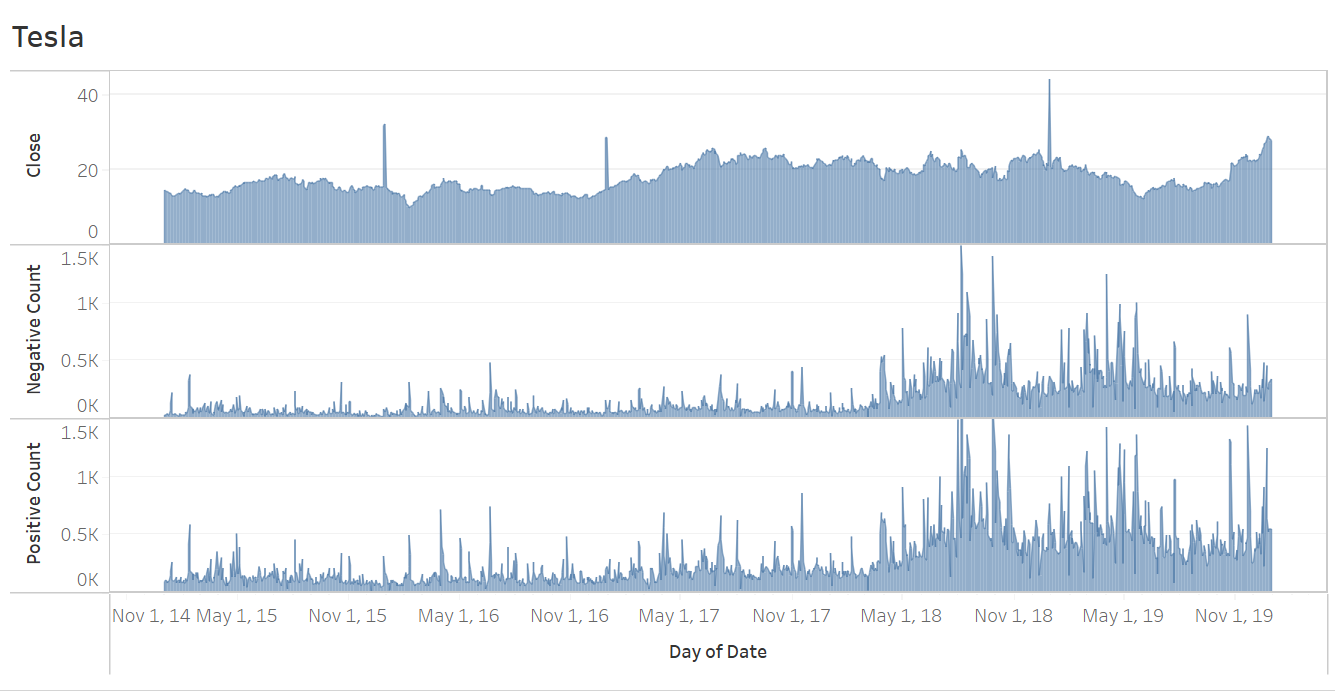

In [64]:
sdf_tsla = spark.createDataFrame(df3_tsla)

In [65]:
sdf_tsla.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|
+-------------------+--------------+-------------+--------------+-----+----------+
|2015-01-05 00:00:00|            30|          137|           108|14.01|     14.62|
|2015-01-06 00:00:00|            34|          125|            80|14.09|     14.01|
|2015-01-07 00:00:00|            29|          128|            93|14.06|     14.09|
|2015-01-08 00:00:00|            28|          112|            95|14.04|     14.06|
|2015-01-09 00:00:00|            28|          149|            87|13.78|     14.04|
+-------------------+--------------+-------------+--------------+-----+----------+
only showing top 5 rows



In [66]:
# Import required modules
from pyspark.ml.feature import VectorAssembler

# Define the feature column names
feature_cols = ['negative_count','neutral_count','positive_count','prev_close']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform the data using the VectorAssembler
data_tsla = assembler.transform(sdf_tsla)
data_tsla = data_aapl.na.drop()

# Split the data into training and test sets
train_data_tsla = data_tsla.limit(int(0.80 * data_tsla.count()))
test_data_tsla = data_tsla.subtract(train_data_tsla)

In [67]:
from pyspark.ml.feature import StandardScaler

# Define the scaler and fit it on the training data
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model_tsla = scaler.fit(train_data_tsla)

# Apply the scaler on both training and test data
train_data_tsla = scaler_model_tsla.transform(train_data_tsla)
test_data_tsla = scaler_model_tsla.transform(test_data_tsla)


In [68]:
train_data_tsla.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|            features|     scaled_features|
+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|2015-01-05 00:00:00|         210.0|        469.0|         461.0|26.56|     27.33|[210.0,469.0,461....|[0.28314370911677...|
|2015-01-06 00:00:00|         167.0|        520.0|         496.0|26.57|     26.56|[167.0,520.0,496....|[-0.0465523069228...|
|2015-01-07 00:00:00|         170.0|        475.0|         446.0|26.94|     26.57|[170.0,475.0,446....|[-0.0235502592921...|
|2015-01-08 00:00:00|         163.0|        696.0|         620.0|27.97|     26.94|[163.0,696.0,620....|[-0.0772217037637...|
|2015-01-09 00:00:00|         169.0|        519.0|         426.0| 28.0|     27.97|[169.0,519.0,426....|[-0.0312176085024...|


In [69]:
# Import required modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

# Train linear regression model on the training data
lr = LinearRegression(featuresCol='scaled_features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data_tsla)

# Train decision tree regression model on the training data
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='Close', maxDepth=5, minInstancesPerNode=20)
dt_model = dt.fit(train_data_tsla)

# Train gradient boosted tree regression model on the training data
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='Close', maxIter=10, maxDepth=5, minInstancesPerNode=20)
gbt_model = gbt.fit(train_data_tsla)

# Make predictions on the train data using all models
train_lr_predictions_tsla = lr_model.transform(train_data_tsla)
train_dt_predictions_tsla = dt_model.transform(train_data_tsla)
train_gbt_predictions_tsla = gbt_model.transform(train_data_tsla)

# Make predictions on the test data using all models
test_lr_predictions_tsla = lr_model.transform(test_data_tsla)
test_dt_predictions_tsla = dt_model.transform(test_data_tsla)
test_gbt_predictions_tsla = gbt_model.transform(test_data_tsla)

# Evaluate the models using both RMSE and R2 metrics
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
r2_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

train_lr_rmse_tsla = rmse_evaluator.evaluate(train_lr_predictions_tsla)
train_dt_rmse_tsla = rmse_evaluator.evaluate(train_dt_predictions_tsla)
train_gbt_rmse_tsla = rmse_evaluator.evaluate(train_gbt_predictions_tsla)

test_lr_rmse_tsla = rmse_evaluator.evaluate(test_lr_predictions_tsla)
test_dt_rmse_tsla = rmse_evaluator.evaluate(test_dt_predictions_tsla)
test_gbt_rmse_tsla = rmse_evaluator.evaluate(test_gbt_predictions_tsla)

train_lr_r2_tsla = r2_evaluator.evaluate(train_lr_predictions_tsla)
train_dt_r2_tsla = r2_evaluator.evaluate(train_dt_predictions_tsla)
train_gbt_r2_tsla = r2_evaluator.evaluate(train_gbt_predictions_tsla)

test_lr_r2_tsla = r2_evaluator.evaluate(test_lr_predictions_tsla)
test_dt_r2_tsla = r2_evaluator.evaluate(test_dt_predictions_tsla)
test_gbt_r2_tsla = r2_evaluator.evaluate(test_gbt_predictions_tsla)

# Print the train RMSE and R2 scores for all models
print("Linear Regression train rmse score: ", train_lr_rmse_tsla)
print("Linear Regression train r2 score: ", train_lr_r2_tsla)

print("Decision Tree Regression train rmse score:", train_dt_rmse_tsla)
print("Decision Tree Regression train r2 score:", train_dt_r2_tsla)

print("Gradient Boosted Tree Regression train rmse score", train_gbt_rmse_tsla)
print("Gradient Boosted Tree Regression train r2 score", train_gbt_r2_tsla)

# Print the test RMSE and R2 scores for all models
print("Linear Regression test rmse score: ", test_lr_rmse_tsla)
print("Linear Regression test r2 score: ", test_lr_r2_tsla)

print("Decision Tree Regression test rmse score:", test_dt_rmse_tsla)
print("Decision Tree Regression test r2 score:", test_dt_r2_tsla)

print("Gradient Boosted Tree Regression test rmse score", test_gbt_rmse_tsla)
print("Gradient Boosted Tree Regression test r2 score", test_gbt_r2_tsla)

Linear Regression train rmse score:  0.6336236172297024
Linear Regression train r2 score:  0.994772614097202
Decision Tree Regression train rmse score: 0.7307593500630499
Decision Tree Regression train r2 score: 0.993047025908115
Gradient Boosted Tree Regression train rmse score 0.647523635255347
Gradient Boosted Tree Regression train r2 score 0.9945407485283293
Linear Regression test rmse score:  1.121892769356814
Linear Regression test r2 score:  0.9830506795185335
Decision Tree Regression test rmse score: 5.188825058954258
Decision Tree Regression test r2 score: 0.6374335193722067
Gradient Boosted Tree Regression test rmse score 5.283977987000317
Gradient Boosted Tree Regression test r2 score 0.624014070295468


In [70]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Random Forest regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross-validation object
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=r2_evaluator, numFolds=5)

# Train the model on the training data using cross-validation
cv_model = cv.fit(train_data_tsla)

# Make predictions on the test and train data
test_rf_predictions_tsla = cv_model.transform(test_data_tsla)
train_rf_predictions_tsla = cv_model.transform(train_data_tsla)

# Evaluate the model performance using the train r2 score and rmse
train_rf_r2_tsla = r2_evaluator.evaluate(train_rf_predictions_tsla)
train_rf_rmse_tsla = rmse_evaluator.evaluate(train_rf_predictions_tsla)

# Evaluate the model performance using the test r2 score and rmse
test_rf_r2_tsla = r2_evaluator.evaluate(test_rf_predictions_tsla)
test_rf_rmse_tsla = rmse_evaluator.evaluate(test_rf_predictions_tsla)

print("Random Forest Regression train rmse score", train_rf_rmse_tsla)
print("Random Forest Regression train r2 score", train_rf_r2_tsla)

print("Random Forest Regression test rmse score", test_rf_rmse_tsla)
print("Random Forest Regression test r2 score", test_rf_r2_tsla)

Random Forest Regression train rmse score 0.34332307902574016
Random Forest Regression train r2 score 0.9984652846145816
Random Forest Regression test rmse score 6.027580166557075
Random Forest Regression test r2 score 0.5107446493885122


In [71]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the L1 regularized Linear Regression model (Lasso)
lr_l1 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=1, solver='normal')

# Train the L1 regularized Linear Regression model on the training data
lr_l1_model = lr_l1.fit(train_data_tsla)

# Make predictions on the test data using the L1 regularized model
train_predictions_l1_tsla = lr_l1_model.transform(train_data_tsla)
test_predictions_l1_tsla = lr_l1_model.transform(test_data_tsla)

# Evaluate the performance of the L1 regularized model using the r2 score
train_r2_l1_tsla = r2_evaluator.evaluate(train_predictions_l1_tsla)
train_rmse_l1_tsla = rmse_evaluator.evaluate(train_predictions_l1_tsla)
print('L1 Regularized Linear Regression train r2:', train_r2_l1_tsla)
print('L1 Regularized Linear Regression train rmse:', train_rmse_l1_tsla)

test_r2_l1_tsla = r2_evaluator.evaluate(test_predictions_l1_tsla)
test_rmse_l1_tsla = rmse_evaluator.evaluate(test_predictions_l1_tsla)
print('L1 Regularized Linear Regression test r2:', test_r2_l1_tsla)
print('L1 Regularized Linear Regression test rmse:', test_rmse_l1_tsla)

# Define the L2 regularized Linear Regression model (Ridge)
lr_l2 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0, solver='normal')

# Train the L2 regularized Linear Regression model on the training data
lr_l2_model = lr_l2.fit(train_data_tsla)

# Make predictions on the test data using the L2 regularized model
train_predictions_l2_tsla = lr_l2_model.transform(train_data_tsla)
test_predictions_l2_tsla = lr_l2_model.transform(test_data_tsla)

# Evaluate the performance of the L2 regularized model using the r2 score
train_r2_l2_tsla = r2_evaluator.evaluate(train_predictions_l2_tsla)
train_rmse_l2_tsla = rmse_evaluator.evaluate(train_predictions_l2_tsla)
print('L2 Regularized Linear Regression train r2:', train_r2_l2_tsla)
print('L2 Regularized Linear Regression train rmse:', train_rmse_l2_tsla)

test_r2_l2_tsla = r2_evaluator.evaluate(test_predictions_l2_tsla)
test_rmse_l2_tsla = rmse_evaluator.evaluate(test_predictions_l2_tsla)
print('L2 Regularized Linear Regression test r2:', test_r2_l2_tsla)
print('L2 Regularized Linear Regression test rmse:', test_rmse_l2_tsla)


L1 Regularized Linear Regression train r2: 0.9946950468318986
L1 Regularized Linear Regression train rmse: 0.6383073605447964
L1 Regularized Linear Regression test r2: 0.982585406753564
L1 Regularized Linear Regression test rmse: 1.1371869592993842
L2 Regularized Linear Regression train r2: 0.9946931544300287
L2 Regularized Linear Regression train rmse: 0.6384212000358234
L2 Regularized Linear Regression test r2: 0.9763783867433319
L2 Regularized Linear Regression test rmse: 1.3244329615296557


In [72]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Train an XGBoost Regressor
xgb = SparkXGBRegressor(features_col='features', label_col='Close')
evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

# Fit the model
model = xgb.fit(train_data_tsla)

# Make predictions on the test and train data
train_predictions_xgb_tsla = model.transform(train_data_tsla)
test_predictions_xgb_tsla = model.transform(test_data_tsla)

train_r2_xgb_tsla = r2_evaluator.evaluate(train_predictions_xgb_tsla)
train_rmse_xgb_tsla= rmse_evaluator.evaluate(train_predictions_xgb_tsla)
print('xgb Regressor train r2:', train_r2_xgb_tsla)
print('xgb Regressor train rmse:', train_rmse_xgb_tsla)

test_r2_xgb_tsla = r2_evaluator.evaluate(test_predictions_xgb_tsla)
test_rmse_xgb_tsla = rmse_evaluator.evaluate(test_predictions_xgb_tsla)
print('xgb Regressor test r2:', test_r2_xgb_tsla)
print('xgb Regressor test rmse:', test_rmse_xgb_tsla)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgb Regressor train r2: 0.9999194320971497
xgb Regressor train rmse: 0.0786629274945896
xgb Regressor test r2: 0.7225146760271699
xgb Regressor test rmse: 4.539366125787608


# **Microsoft**

In [73]:
from pyspark.sql.functions import col
df_tweet_msft= df_tweet.filter((col("ticker_symbol") == "MSFT"))

In [74]:
df_tweet_msft=df_tweet_msft.drop("tweet_id","company_name","tweet","afinn_score","vander_score","total_engagements")
df_tweet_msft.show(5)

+-------------+-------------------+----------------+
|ticker_symbol|         tweet_date|vander_sentiment|
+-------------+-------------------+----------------+
|         MSFT|2015-01-01 20:51:55|         Neutral|
|         MSFT|2015-01-01 19:12:39|         Neutral|
|         MSFT|2015-01-01 18:53:06|        Negative|
|         MSFT|2015-01-01 17:32:51|         Neutral|
|         MSFT|2015-01-01 17:31:20|        Positive|
+-------------+-------------------+----------------+
only showing top 5 rows



In [75]:
pandas_df_msft = df_tweet_msft.toPandas()

In [76]:
import pandas as pd
import datetime
pandas_df_msft['tweet_date'] = pd.to_datetime(pandas_df_msft['tweet_date'], errors='coerce')
pandas_df_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375711 entries, 0 to 375710
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ticker_symbol     375711 non-null  object        
 1   tweet_date        373695 non-null  datetime64[ns]
 2   vander_sentiment  375711 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.6+ MB


In [77]:
pandas_df_msft["tweet_date"] = pandas_df_msft["tweet_date"].dt.date

In [78]:
# Filter the data for apple company
df_msft=pandas_df_msft[pandas_df_msft["ticker_symbol"]=="MSFT"]
df_msft

,ticker_symbol,tweet_date,vander_sentiment
0,MSFT,2015-01-01,Neutral
1,MSFT,2015-01-01,Neutral
2,MSFT,2015-01-01,Negative
3,MSFT,2015-01-01,Neutral
4,MSFT,2015-01-01,Positive
...,...,...,...
375706,MSFT,2019-12-31,Positive
375707,MSFT,2019-12-31,Positive
375708,MSFT,2019-12-31,Positive
375709,MSFT,2019-12-31,Neutral


In [79]:
# Finding how many negative,positive and neutral tweets are present each day
df_msft12=df_msft.groupby(["tweet_date", "vander_sentiment"]).size().reset_index().rename(columns={0: "count"})
df_msft

,ticker_symbol,tweet_date,vander_sentiment
0,MSFT,2015-01-01,Neutral
1,MSFT,2015-01-01,Neutral
2,MSFT,2015-01-01,Negative
3,MSFT,2015-01-01,Neutral
4,MSFT,2015-01-01,Positive
...,...,...,...
375706,MSFT,2019-12-31,Positive
375707,MSFT,2019-12-31,Positive
375708,MSFT,2019-12-31,Positive
375709,MSFT,2019-12-31,Neutral


In [80]:
new_df_msft = df_msft12.pivot_table(index='tweet_date', columns='vander_sentiment', values='count').reset_index().rename_axis(None, axis=1).fillna(0)
new_df_msft.columns = ['date', 'negative_count', 'neutral_count', 'positive_count']

In [81]:
new_df_msft

,date,negative_count,neutral_count,positive_count
0,2015-01-01,8.0,23.0,23.0
1,2015-01-02,17.0,39.0,51.0
2,2015-01-03,9.0,25.0,25.0
3,2015-01-04,4.0,12.0,18.0
4,2015-01-05,18.0,54.0,37.0
...,...,...,...,...
1821,2019-12-27,28.0,87.0,93.0
1822,2019-12-28,6.0,43.0,33.0
1823,2019-12-29,7.0,29.0,32.0
1824,2019-12-30,36.0,87.0,121.0


In [82]:
new_df_msft['date'] = pd.to_datetime(new_df_msft['date'])
new_df_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1826 non-null   datetime64[ns]
 1   negative_count  1826 non-null   float64       
 2   neutral_count   1826 non-null   float64       
 3   positive_count  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.2 KB


In [83]:
df1_msft=pd.read_csv("/content/drive/MyDrive/archive/MSFT_ALL.csv")

In [84]:
df1_msft.head(5)

,Date,Open,High,Low,Close,Volume
0,12/31/2019,156.77,157.77,156.45,157.70,"18,393,381"
1,12/30/2019,158.99,159.02,156.73,157.59,"16,356,720"
2,12/27/2019,159.45,159.55,158.22,158.96,"18,414,350"
3,12/26/2019,157.56,158.73,157.40,158.67,"14,526,930"
4,12/24/2019,157.48,157.71,157.12,157.38,"8,989,150"


In [85]:
df1_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1263 non-null   object 
 1   Open    1263 non-null   float64
 2   High    1263 non-null   float64
 3   Low     1263 non-null   float64
 4   Close   1263 non-null   float64
 5   Volume  1263 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.3+ KB


In [86]:
# Converting to datetime
df1_msft['Date'] = pd.to_datetime(df1_msft['Date'])
df1_msft.head(5)

,Date,Open,High,Low,Close,Volume
0,2019-12-31,156.77,157.77,156.45,157.70,"18,393,381"
1,2019-12-30,158.99,159.02,156.73,157.59,"16,356,720"
2,2019-12-27,159.45,159.55,158.22,158.96,"18,414,350"
3,2019-12-26,157.56,158.73,157.40,158.67,"14,526,930"
4,2019-12-24,157.48,157.71,157.12,157.38,"8,989,150"


In [87]:
# merging data frames
df2_msft = pd.merge(new_df_msft, df1_msft.rename(columns={'Date': 'date'}), on='date', how='inner')
df2_msft.head()

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,17.0,39.0,51.0,46.66,47.42,46.54,46.76,"27,913,850"
1,2015-01-05,18.0,54.0,37.0,46.37,46.73,46.25,46.33,"39,673,871"
2,2015-01-06,11.0,37.0,30.0,46.38,46.75,45.54,45.65,"36,447,848"
3,2015-01-07,11.0,40.0,37.0,45.98,46.46,45.49,46.23,"29,114,061"
4,2015-01-08,13.0,57.0,63.0,46.75,47.75,46.72,47.59,"29,645,199"


In [88]:
df2_msft = df2_msft.sort_values(by="date")
df2_msft.head(10)

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,17.0,39.0,51.0,46.66,47.42,46.54,46.76,"27,913,850"
1,2015-01-05,18.0,54.0,37.0,46.37,46.73,46.25,46.33,"39,673,871"
2,2015-01-06,11.0,37.0,30.0,46.38,46.75,45.54,45.65,"36,447,848"
3,2015-01-07,11.0,40.0,37.0,45.98,46.46,45.49,46.23,"29,114,061"
4,2015-01-08,13.0,57.0,63.0,46.75,47.75,46.72,47.59,"29,645,199"
5,2015-01-09,11.0,40.0,35.0,47.61,47.82,46.90,47.19,"23,944,180"
6,2015-01-12,9.0,30.0,33.0,47.42,47.54,46.36,46.60,"23,651,891"
7,2015-01-13,13.0,57.0,54.0,46.97,47.91,46.06,46.36,"35,270,602"
8,2015-01-14,17.0,61.0,45.0,45.96,46.24,45.62,45.96,"29,719,580"
9,2015-01-15,13.0,49.0,48.0,46.22,46.38,45.41,45.48,"32,750,779"


In [89]:
df2_msft.to_csv('MSFT_sentimental_stock_f.csv', index=False)
from google.colab import files
files.download("MSFT_sentimental_stock_f.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
df3_msft=df2_msft[["date","negative_count","neutral_count","positive_count","Close"]]
df3_msft["prev_close"] = df2_msft["Close"].shift(1)
df3_msft = df3_msft.drop(0)

<ipython-input-90-4ffd976e1123>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_msft["prev_close"] = df2_msft["Close"].shift(1)


In [91]:
df3_msft.head()

,date,negative_count,neutral_count,positive_count,Close,prev_close
1,2015-01-05,18.0,54.0,37.0,46.33,46.76
2,2015-01-06,11.0,37.0,30.0,45.65,46.33
3,2015-01-07,11.0,40.0,37.0,46.23,45.65
4,2015-01-08,13.0,57.0,63.0,47.59,46.23
5,2015-01-09,11.0,40.0,35.0,47.19,47.59


## **Tableau Visualization for Microsoft**

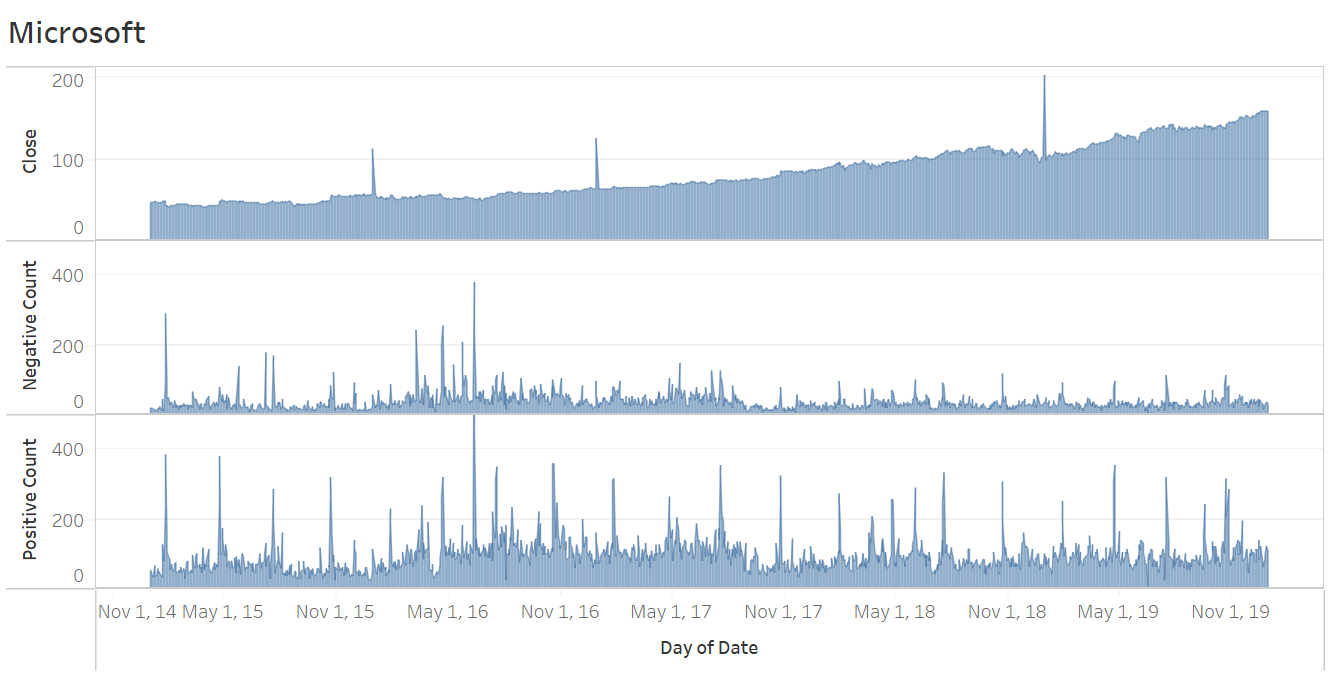

In [92]:
sdf_msft = spark.createDataFrame(df3_msft)

In [93]:
sdf_msft.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|
+-------------------+--------------+-------------+--------------+-----+----------+
|2015-01-05 00:00:00|          18.0|         54.0|          37.0|46.33|     46.76|
|2015-01-06 00:00:00|          11.0|         37.0|          30.0|45.65|     46.33|
|2015-01-07 00:00:00|          11.0|         40.0|          37.0|46.23|     45.65|
|2015-01-08 00:00:00|          13.0|         57.0|          63.0|47.59|     46.23|
|2015-01-09 00:00:00|          11.0|         40.0|          35.0|47.19|     47.59|
+-------------------+--------------+-------------+--------------+-----+----------+
only showing top 5 rows



In [94]:
# Import required modules
from pyspark.ml.feature import VectorAssembler

# Define the feature column names
feature_cols = ['negative_count','neutral_count','positive_count','prev_close']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform the data using the VectorAssembler
data_msft = assembler.transform(sdf_msft)
data_msft = data_msft.na.drop()

# Split the data into training and test sets
train_data_msft = data_msft.limit(int(0.80 * data_msft.count()))
test_data_msft= data_msft.subtract(train_data_msft)


In [95]:
from pyspark.ml.feature import StandardScaler

# Define the scaler and fit it on the training data
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(train_data_msft)

# Apply the scaler on both training and test data
train_data_msft = scaler_model.transform(train_data_msft)
test_data_msft = scaler_model.transform(test_data_msft)


In [96]:
train_data_msft.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|            features|     scaled_features|
+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|2015-01-05 00:00:00|          18.0|         54.0|          37.0|46.33|     46.76|[18.0,54.0,37.0,4...|[-0.6294668931510...|
|2015-01-06 00:00:00|          11.0|         37.0|          30.0|45.65|     46.33|[11.0,37.0,30.0,4...|[-0.8695924489882...|
|2015-01-07 00:00:00|          11.0|         40.0|          37.0|46.23|     45.65|[11.0,40.0,37.0,4...|[-0.8695924489882...|
|2015-01-08 00:00:00|          13.0|         57.0|          63.0|47.59|     46.23|[13.0,57.0,63.0,4...|[-0.8009851473204...|
|2015-01-09 00:00:00|          11.0|         40.0|          35.0|47.19|     47.59|[11.0,40.0,35.0,4...|[-0.8695924489882...|


In [97]:
# Import required modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

# Train linear regression model on the training data
lr = LinearRegression(featuresCol='scaled_features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data_msft)

# Train decision tree regression model on the training data
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='Close', maxDepth=5, minInstancesPerNode=20)
dt_model = dt.fit(train_data_msft)

# Train gradient boosted tree regression model on the training data
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='Close', maxIter=10, maxDepth=5, minInstancesPerNode=20)
gbt_model = gbt.fit(train_data_msft)

# Make predictions on the train data using all models
train_lr_predictions_msft = lr_model.transform(train_data_msft)
train_dt_predictions_msft = dt_model.transform(train_data_msft)
train_gbt_predictions_msft = gbt_model.transform(train_data_msft)

# Make predictions on the test data using all models
test_lr_predictions_msft = lr_model.transform(test_data_msft)
test_dt_predictions_msft = dt_model.transform(test_data_msft)
test_gbt_predictions_msft = gbt_model.transform(test_data_msft)

# Evaluate the models using both RMSE and R2 metrics
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
r2_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

train_lr_rmse_msft = rmse_evaluator.evaluate(train_lr_predictions_msft)
train_dt_rmse_msft = rmse_evaluator.evaluate(train_dt_predictions_msft)
train_gbt_rmse_msft = rmse_evaluator.evaluate(train_gbt_predictions_msft)

test_lr_rmse_msft = rmse_evaluator.evaluate(test_lr_predictions_msft)
test_dt_rmse_msft = rmse_evaluator.evaluate(test_dt_predictions_msft)
test_gbt_rmse_msft = rmse_evaluator.evaluate(test_gbt_predictions_msft)

train_lr_r2_msft = r2_evaluator.evaluate(train_lr_predictions_msft)
train_dt_r2_msft = r2_evaluator.evaluate(train_dt_predictions_msft)
train_gbt_r2_msft = r2_evaluator.evaluate(train_gbt_predictions_msft)

test_lr_r2_msft = r2_evaluator.evaluate(test_lr_predictions_msft)
test_dt_r2_msft = r2_evaluator.evaluate(test_dt_predictions_msft)
test_gbt_r2_msft = r2_evaluator.evaluate(test_gbt_predictions_msft)

# Print the train RMSE and R2 scores for all models
print("Linear Regression train rmse score: ", train_lr_rmse_msft)
print("Linear Regression train r2 score: ", train_lr_r2_msft)

print("Decision Tree Regression train rmse score:", train_dt_rmse_msft)
print("Decision Tree Regression train r2 score:", train_dt_r2_msft)

print("Gradient Boosted Tree Regression train rmse score", train_gbt_rmse_msft)
print("Gradient Boosted Tree Regression train r2 score", train_gbt_r2_msft)

# Print the test RMSE and R2 scores for all models
print("Linear Regression test rmse score: ", test_lr_rmse_msft)
print("Linear Regression test r2 score: ", test_lr_r2_msft)

print("Decision Tree Regression test rmse score:", test_dt_rmse_msft)
print("Decision Tree Regression test r2 score:", test_dt_r2_msft)

print("Gradient Boosted Tree Regression test rmse score", test_gbt_rmse_msft)
print("Gradient Boosted Tree Regression test r2 score", test_gbt_r2_msft)


Linear Regression train rmse score:  1.143784423655566
Linear Regression train r2 score:  0.9971835619435705
Decision Tree Regression train rmse score: 1.4461707073396879
Decision Tree Regression train r2 score: 0.9954975285343433
Gradient Boosted Tree Regression train rmse score 1.331332982692281
Gradient Boosted Tree Regression train r2 score 0.9961842032742693
Linear Regression test rmse score:  1.8966318764377934
Linear Regression test r2 score:  0.9839078959557717
Decision Tree Regression test rmse score: 23.25401159663493
Decision Tree Regression test r2 score: -1.4190369964091452
Gradient Boosted Tree Regression test rmse score 23.353027752280145
Gradient Boosted Tree Regression test r2 score -1.4396814939624814


In [98]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Random Forest regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross-validation object
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=r2_evaluator, numFolds=5)

# Train the model on the training data using cross-validation
cv_model = cv.fit(train_data_msft)

# Make predictions on the test and train data
test_rf_predictions_msft = cv_model.transform(test_data_msft)
train_rf_predictions_msft = cv_model.transform(train_data_msft)

# Evaluate the model performance using the train r2 score and rmse
train_rf_r2_msft = r2_evaluator.evaluate(train_rf_predictions_msft)
train_rf_rmse_msft = rmse_evaluator.evaluate(train_rf_predictions_msft)

# Evaluate the model performance using the test r2 score and rmse
test_rf_r2_msft = r2_evaluator.evaluate(test_rf_predictions_msft)
test_rf_rmse_msft = rmse_evaluator.evaluate(test_rf_predictions_msft)

print("Random Forest Regression train rmse score", train_rf_rmse_msft)
print("Random Forest Regression train r2 score", train_rf_r2_msft)

print("Random Forest Regression test rmse score", test_rf_rmse_msft)
print("Random Forest Regression test r2 score", test_rf_r2_msft)

Random Forest Regression train rmse score 0.6888080242423317
Random Forest Regression train r2 score 0.9989785708596359
Random Forest Regression test rmse score 25.769046254145017
Random Forest Regression test r2 score -1.9705949001105996


In [99]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the L1 regularized Linear Regression model (Lasso)
lr_l1 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=1, solver='normal')

# Train the L1 regularized Linear Regression model on the training data
lr_l1_model = lr_l1.fit(train_data_msft)

# Make predictions on the test data using the L1 regularized model
train_predictions_l1_msft = lr_l1_model.transform(train_data_msft)
test_predictions_l1_msft = lr_l1_model.transform(test_data_msft)

# Evaluate the performance of the L1 regularized model using the r2 score
train_r2_l1_msft = r2_evaluator.evaluate(train_predictions_l1_msft)
train_rmse_l1_msft = rmse_evaluator.evaluate(train_predictions_l1_msft)
print('L1 Regularized Linear Regression train r2:', train_r2_l1_msft)
print('L1 Regularized Linear Regression train rmse:', train_rmse_l1_msft)

test_r2_l1_msft = r2_evaluator.evaluate(test_predictions_l1_msft)
test_rmse_l1_msft = rmse_evaluator.evaluate(test_predictions_l1_msft)
print('L1 Regularized Linear Regression test r2:', test_r2_l1_msft)
print('L1 Regularized Linear Regression test rmse:', test_rmse_l1_msft)

# Define the L2 regularized Linear Regression model (Ridge)
lr_l2 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0, solver='normal')

# Train the L2 regularized Linear Regression model on the training data
lr_l2_model = lr_l2.fit(train_data_msft)

# Make predictions on the test data using the L2 regularized model
train_predictions_l2_msft = lr_l2_model.transform(train_data_msft)
test_predictions_l2_msft = lr_l2_model.transform(test_data_msft)

# Evaluate the performance of the L2 regularized model using the r2 score
train_r2_l2_msft = r2_evaluator.evaluate(train_predictions_l2_msft)
train_rmse_l2_msft = rmse_evaluator.evaluate(train_predictions_l2_msft)
print('L2 Regularized Linear Regression train r2:', train_r2_l2_msft)
print('L2 Regularized Linear Regression train rmse:', train_rmse_l2_msft)

test_r2_l2_msft = r2_evaluator.evaluate(test_predictions_l2_msft)
test_rmse_l2_msft = rmse_evaluator.evaluate(test_predictions_l2_msft)
print('L2 Regularized Linear Regression test r2:', test_r2_l2_msft)
print('L2 Regularized Linear Regression test rmse:', test_rmse_l2_msft)

L1 Regularized Linear Regression train r2: 0.997183072571696
L1 Regularized Linear Regression train rmse: 1.1438837888118345
L1 Regularized Linear Regression test r2: 0.9838973077643883
L1 Regularized Linear Regression test rmse: 1.8972557413773554
L2 Regularized Linear Regression train r2: 0.9972754191310467
L2 Regularized Linear Regression train rmse: 1.124977735392936
L2 Regularized Linear Regression test r2: 0.9837249440912273
L2 Regularized Linear Regression test rmse: 1.9073828528504384


In [100]:
pip install xgboost==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
pip install sparkxgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Train an XGBoost Regressor
xgb = SparkXGBRegressor(features_col='features', label_col='Close')
evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

# Fit the model
model = xgb.fit(train_data_msft)

# Make predictions on the test and train data
train_predictions_xgb_msft = model.transform(train_data_msft)
test_predictions_xgb_msft = model.transform(test_data_msft)

train_r2_xgb_msft = r2_evaluator.evaluate(train_predictions_xgb_msft)
train_rmse_xgb_msft = rmse_evaluator.evaluate(train_predictions_xgb_msft)
print('xgb Regressor train r2:', train_r2_xgb_msft)
print('xgb Regressor train rmse:', train_rmse_xgb_msft)

test_r2_xgb_msft = r2_evaluator.evaluate(test_predictions_xgb_msft)
test_rmse_xgb_msft = rmse_evaluator.evaluate(test_predictions_xgb_msft)
print('xgb Regressor test r2:', test_r2_xgb_msft)
print('xgb Regressor test rmse:', test_rmse_xgb_msft)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgb Regressor train r2: 0.9999481294313483
xgb Regressor train rmse: 0.15522246663000172
xgb Regressor test r2: -1.452698777328767
xgb Regressor test rmse: 23.41524664411827


# **Amazon**

In [103]:
from pyspark.sql.functions import col
df_tweet_amzn= df_tweet.filter((col("ticker_symbol") == "AMZN"))

In [104]:
df_tweet_amzn=df_tweet_amzn.drop("tweet_id","company_name","tweet","afinn_score","vander_score","total_engagements")
df_tweet_amzn.show(5)

+-------------+-------------------+----------------+
|ticker_symbol|         tweet_date|vander_sentiment|
+-------------+-------------------+----------------+
|         AMZN|2015-01-01 23:59:49|         Neutral|
|         AMZN|2015-01-01 23:59:48|         Neutral|
|         AMZN|2015-01-01 22:29:03|        Positive|
|         AMZN|2015-01-01 21:59:48|         Neutral|
|         AMZN|2015-01-01 19:59:48|         Neutral|
+-------------+-------------------+----------------+
only showing top 5 rows



In [105]:
pandas_df_amzn = df_tweet_amzn.toPandas()

In [106]:
import pandas as pd
import datetime
pandas_df_amzn['tweet_date'] = pd.to_datetime(pandas_df_amzn['tweet_date'], errors='coerce')
pandas_df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718715 entries, 0 to 718714
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ticker_symbol     718715 non-null  object        
 1   tweet_date        713040 non-null  datetime64[ns]
 2   vander_sentiment  718715 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 16.5+ MB


In [107]:
pandas_df_amzn["tweet_date"] = pandas_df_amzn["tweet_date"].dt.date

In [108]:
# Filter the data for apple company
df_amzn=pandas_df_amzn[pandas_df_amzn["ticker_symbol"]=="AMZN"]
df_amzn

,ticker_symbol,tweet_date,vander_sentiment
0,AMZN,2015-01-01,Neutral
1,AMZN,2015-01-01,Neutral
2,AMZN,2015-01-01,Positive
3,AMZN,2015-01-01,Neutral
4,AMZN,2015-01-01,Neutral
...,...,...,...
718710,AMZN,2019-12-31,Negative
718711,AMZN,NaT,Positive
718712,AMZN,2019-12-31,Positive
718713,AMZN,2019-12-31,Positive


In [109]:
# Finding how many negative,positive and neutral tweets are present each day
df_amzn12=df_amzn.groupby(["tweet_date", "vander_sentiment"]).size().reset_index().rename(columns={0: "count"})
df_amzn12

,tweet_date,vander_sentiment,count
0,2015-01-01,Negative,61
1,2015-01-01,Neutral,28
2,2015-01-01,Positive,41
3,2015-01-02,Negative,34
4,2015-01-02,Neutral,64
...,...,...,...
5472,2019-12-30,Neutral,155
5473,2019-12-30,Positive,292
5474,2019-12-31,Negative,59
5475,2019-12-31,Neutral,171


In [110]:
new_df_amzn = df_amzn12.pivot_table(index='tweet_date', columns='vander_sentiment', values='count').reset_index().rename_axis(None, axis=1).fillna(0)
new_df_amzn.columns = ['date', 'negative_count', 'neutral_count', 'positive_count']

In [111]:
new_df_amzn

,date,negative_count,neutral_count,positive_count
0,2015-01-01,61.0,28.0,41.0
1,2015-01-02,34.0,64.0,74.0
2,2015-01-03,8.0,31.0,28.0
3,2015-01-04,10.0,46.0,28.0
4,2015-01-05,29.0,131.0,120.0
...,...,...,...,...
1821,2019-12-27,111.0,341.0,495.0
1822,2019-12-28,25.0,60.0,101.0
1823,2019-12-29,16.0,52.0,82.0
1824,2019-12-30,72.0,155.0,292.0


In [112]:
new_df_amzn['date'] = pd.to_datetime(new_df_amzn['date'])
new_df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1826 non-null   datetime64[ns]
 1   negative_count  1826 non-null   float64       
 2   neutral_count   1826 non-null   float64       
 3   positive_count  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.2 KB


In [113]:
df1_amzn=pd.read_csv("/content/drive/MyDrive/archive/AMZN_ALL.csv")

In [114]:
df1_amzn.head(5)

,Date,Open,High,Low,Close,Volume
0,12/31/2019,92.10,92.66,91.61,92.39,"50,207,599"
1,12/30/2019,93.70,94.20,92.03,92.34,"73,546,119"
2,12/27/2019,94.15,95.07,93.30,93.49,"123,775,078"
3,12/26/2019,90.05,93.52,89.98,93.44,"120,492,158"
4,12/24/2019,89.69,89.78,89.38,89.46,"17,626,740"


In [115]:
df1_amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1263 non-null   object 
 1   Open    1263 non-null   float64
 2   High    1263 non-null   float64
 3   Low     1263 non-null   float64
 4   Close   1263 non-null   float64
 5   Volume  1263 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.3+ KB


In [116]:
df1_amzn['Date'] = pd.to_datetime(df1_amzn['Date'])
df1_amzn.head(5)

,Date,Open,High,Low,Close,Volume
0,2019-12-31,92.10,92.66,91.61,92.39,"50,207,599"
1,2019-12-30,93.70,94.20,92.03,92.34,"73,546,119"
2,2019-12-27,94.15,95.07,93.30,93.49,"123,775,078"
3,2019-12-26,90.05,93.52,89.98,93.44,"120,492,158"
4,2019-12-24,89.69,89.78,89.38,89.46,"17,626,740"


In [117]:
df2_amzn = pd.merge(new_df_amzn, df1_amzn.rename(columns={'Date': 'date'}), on='date', how='inner')
df2_amzn.head()

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,34.0,64.0,74.0,15.63,15.74,15.35,15.43,"55,762,019"
1,2015-01-05,29.0,131.0,120.0,15.35,15.42,15.04,15.11,"55,484,619"
2,2015-01-06,28.0,85.0,91.0,15.11,15.15,14.62,14.76,"70,380,679"
3,2015-01-07,36.0,92.0,64.0,14.88,15.06,14.77,14.92,"52,806,979"
4,2015-01-08,35.0,99.0,81.0,15.02,15.16,14.81,15.02,"61,767,959"


In [118]:
df2_amzn = df2_amzn.sort_values(by="date")
df2_amzn.head(10)

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,34.0,64.0,74.0,15.63,15.74,15.35,15.43,"55,762,019"
1,2015-01-05,29.0,131.0,120.0,15.35,15.42,15.04,15.11,"55,484,619"
2,2015-01-06,28.0,85.0,91.0,15.11,15.15,14.62,14.76,"70,380,679"
3,2015-01-07,36.0,92.0,64.0,14.88,15.06,14.77,14.92,"52,806,979"
4,2015-01-08,35.0,99.0,81.0,15.02,15.16,14.81,15.02,"61,767,959"
5,2015-01-09,23.0,106.0,75.0,15.07,15.14,14.83,14.85,"51,847,199"
6,2015-01-12,36.0,96.0,93.0,14.88,14.93,14.46,14.57,"68,427,839"
7,2015-01-13,65.0,155.0,187.0,14.87,15.07,14.66,14.74,"82,728,839"
8,2015-01-14,47.0,119.0,114.0,14.60,14.80,14.33,14.66,"110,773,318"
9,2015-01-15,35.0,149.0,94.0,14.70,14.80,14.34,14.35,"88,383,919"


In [119]:
df2_amzn.to_csv('AMZN_sentimental_stock_f.csv', index=False)
from google.colab import files
files.download("AMZN_sentimental_stock_f.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
df3_amzn=df2_amzn[["date","negative_count","neutral_count","positive_count","Close"]]
df3_amzn["prev_close"] = df2_amzn["Close"].shift(1)
df3_amzn = df3_amzn.drop(0)

<ipython-input-120-ea91bea2f8ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_amzn["prev_close"] = df2_amzn["Close"].shift(1)


In [121]:
df3_amzn.head()

,date,negative_count,neutral_count,positive_count,Close,prev_close
1,2015-01-05,29.0,131.0,120.0,15.11,15.43
2,2015-01-06,28.0,85.0,91.0,14.76,15.11
3,2015-01-07,36.0,92.0,64.0,14.92,14.76
4,2015-01-08,35.0,99.0,81.0,15.02,14.92
5,2015-01-09,23.0,106.0,75.0,14.85,15.02


## **Tableau Visualization for Amazon**

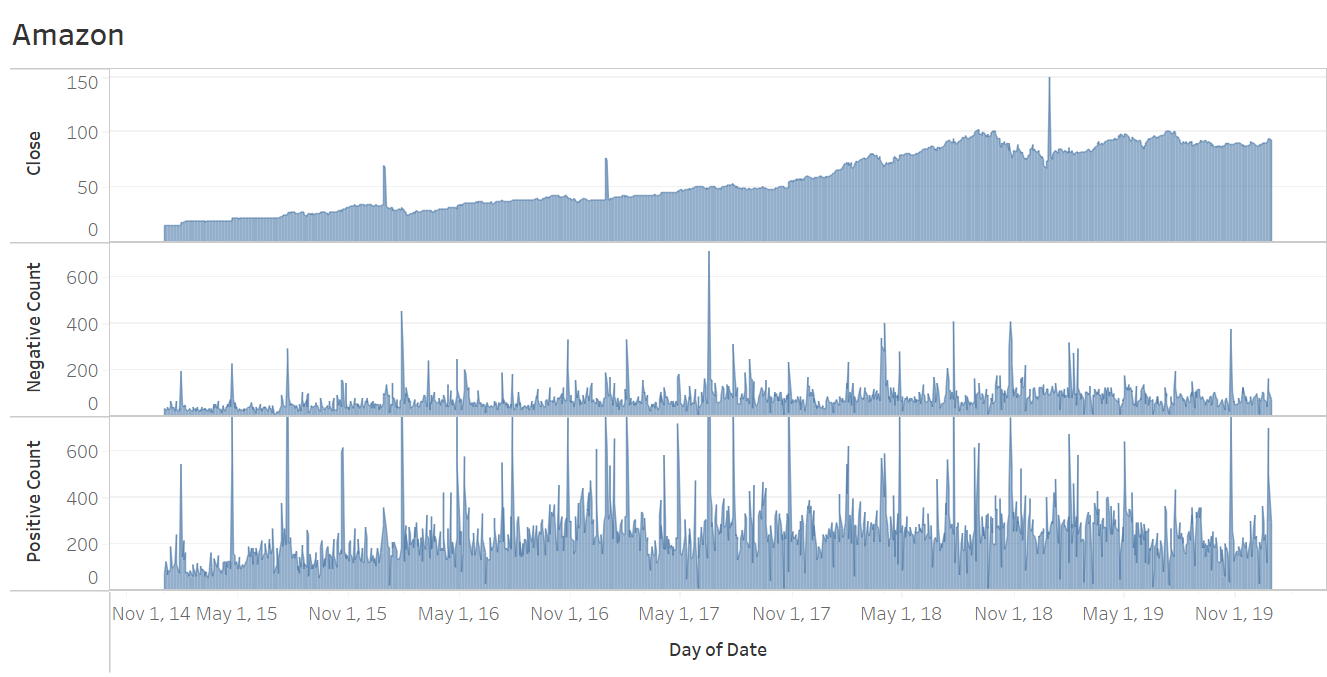

In [122]:
sdf_amzn = spark.createDataFrame(df3_amzn)

In [123]:
sdf_amzn.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|
+-------------------+--------------+-------------+--------------+-----+----------+
|2015-01-05 00:00:00|          29.0|        131.0|         120.0|15.11|     15.43|
|2015-01-06 00:00:00|          28.0|         85.0|          91.0|14.76|     15.11|
|2015-01-07 00:00:00|          36.0|         92.0|          64.0|14.92|     14.76|
|2015-01-08 00:00:00|          35.0|         99.0|          81.0|15.02|     14.92|
|2015-01-09 00:00:00|          23.0|        106.0|          75.0|14.85|     15.02|
+-------------------+--------------+-------------+--------------+-----+----------+
only showing top 5 rows



In [124]:
# Import required modules
from pyspark.ml.feature import VectorAssembler

# Define the feature column names
feature_cols = ['negative_count','neutral_count','positive_count','prev_close']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform the data using the VectorAssembler
data_amzn = assembler.transform(sdf_amzn)
data_amzn = data_amzn.na.drop()

# Split the data into training and test sets
train_data_amzn = data_amzn.limit(int(0.80 * data_amzn.count()))
test_data_amzn = data_amzn.subtract(train_data_amzn)


In [125]:
from pyspark.ml.feature import StandardScaler

# Define the scaler and fit it on the training data
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(train_data_amzn)

# Apply the scaler on both training and test data
train_data_amzn = scaler_model.transform(train_data_amzn)
test_data_amzn = scaler_model.transform(test_data_amzn)


In [126]:
train_data_amzn.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|            features|     scaled_features|
+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|2015-01-05 00:00:00|          29.0|        131.0|         120.0|15.11|     15.43|[29.0,131.0,120.0...|[-0.8188728579056...|
|2015-01-06 00:00:00|          28.0|         85.0|          91.0|14.76|     15.11|[28.0,85.0,91.0,1...|[-0.8371101984558...|
|2015-01-07 00:00:00|          36.0|         92.0|          64.0|14.92|     14.76|[36.0,92.0,64.0,1...|[-0.6912114740542...|
|2015-01-08 00:00:00|          35.0|         99.0|          81.0|15.02|     14.92|[35.0,99.0,81.0,1...|[-0.7094488146044...|
|2015-01-09 00:00:00|          23.0|        106.0|          75.0|14.85|     15.02|[23.0,106.0,75.0,...|[-0.9282969012068...|


In [127]:
# Import required modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

# Train linear regression model on the training data
lr = LinearRegression(featuresCol='scaled_features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data_amzn)

# Train decision tree regression model on the training data
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='Close', maxDepth=5, minInstancesPerNode=20)
dt_model = dt.fit(train_data_amzn)

# Train gradient boosted tree regression model on the training data
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='Close', maxIter=10, maxDepth=5, minInstancesPerNode=20)
gbt_model = gbt.fit(train_data_amzn)

# Make predictions on the train data using all models
train_lr_predictions_amzn = lr_model.transform(train_data_amzn)
train_dt_predictions_amzn = dt_model.transform(train_data_amzn)
train_gbt_predictions_amzn = gbt_model.transform(train_data_amzn)

# Make predictions on the test data using all models
test_lr_predictions_amzn = lr_model.transform(test_data_amzn)
test_dt_predictions_amzn = dt_model.transform(test_data_amzn)
test_gbt_predictions_amzn = gbt_model.transform(test_data_amzn)

# Evaluate the models using both RMSE and R2 metrics
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
r2_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

train_lr_rmse_amzn = rmse_evaluator.evaluate(train_lr_predictions_amzn)
train_dt_rmse_amzn = rmse_evaluator.evaluate(train_dt_predictions_amzn)
train_gbt_rmse_amzn = rmse_evaluator.evaluate(train_gbt_predictions_amzn)

test_lr_rmse_amzn = rmse_evaluator.evaluate(test_lr_predictions_amzn)
test_dt_rmse_amzn = rmse_evaluator.evaluate(test_dt_predictions_amzn)
test_gbt_rmse_amzn = rmse_evaluator.evaluate(test_gbt_predictions_amzn)

train_lr_r2_amzn = r2_evaluator.evaluate(train_lr_predictions_amzn)
train_dt_r2_amzn = r2_evaluator.evaluate(train_dt_predictions_amzn)
train_gbt_r2_amzn = r2_evaluator.evaluate(train_gbt_predictions_amzn)

test_lr_r2_amzn = r2_evaluator.evaluate(test_lr_predictions_amzn)
test_dt_r2_amzn = r2_evaluator.evaluate(test_dt_predictions_amzn)
test_gbt_r2_amzn = r2_evaluator.evaluate(test_gbt_predictions_amzn)

# Print the train RMSE and R2 scores for all models
print("Linear Regression train rmse score: ", train_lr_rmse_amzn)
print("Linear Regression train r2 score: ", train_lr_r2_amzn)

print("Decision Tree Regression train rmse score:", train_dt_rmse_amzn)
print("Decision Tree Regression train r2 score:", train_dt_r2_amzn)

print("Gradient Boosted Tree Regression train rmse score", train_gbt_rmse_amzn)
print("Gradient Boosted Tree Regression train r2 score", train_gbt_r2_amzn)

# Print the test RMSE and R2 scores for all models
print("Linear Regression test rmse score: ", test_lr_rmse_amzn)
print("Linear Regression test r2 score: ", test_lr_r2_amzn)

print("Decision Tree Regression test rmse score:", test_dt_rmse_amzn)
print("Decision Tree Regression test r2 score:", test_dt_r2_amzn)

print("Gradient Boosted Tree Regression test rmse score", test_gbt_rmse_amzn)
print("Gradient Boosted Tree Regression test r2 score", test_gbt_r2_amzn)


Linear Regression train rmse score:  1.0847009017930667
Linear Regression train r2 score:  0.9977352850272805
Decision Tree Regression train rmse score: 1.5561474624459268
Decision Tree Regression train r2 score: 0.9953388288829776
Gradient Boosted Tree Regression train rmse score 1.4628505820337239
Gradient Boosted Tree Regression train r2 score 0.9958809839274604
Linear Regression test rmse score:  1.3904432153889468
Linear Regression test r2 score:  0.9264089498571311
Decision Tree Regression test rmse score: 2.1843411175360647
Decision Tree Regression test r2 score: 0.8183817830984561
Gradient Boosted Tree Regression test rmse score 2.1084006310853587
Gradient Boosted Tree Regression test r2 score 0.8307904927458776


In [128]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Random Forest regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross-validation object
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=r2_evaluator, numFolds=5)

# Train the model on the training data using cross-validation
cv_model = cv.fit(train_data_amzn)

# Make predictions on the test and train data
test_rf_predictions_amzn = cv_model.transform(test_data_amzn)
train_rf_predictions_amzn = cv_model.transform(train_data_amzn)

# Evaluate the model performance using the train r2 score and rmse
train_rf_r2_amzn = r2_evaluator.evaluate(train_rf_predictions_amzn)
train_rf_rmse_amzn = rmse_evaluator.evaluate(train_rf_predictions_amzn)

# Evaluate the model performance using the test r2 score and rmse
test_rf_r2_amzn = r2_evaluator.evaluate(test_rf_predictions_amzn)
test_rf_rmse_amzn = rmse_evaluator.evaluate(test_rf_predictions_amzn)

print("Random Forest Regression train rmse score", train_rf_rmse_amzn)
print("Random Forest Regression train r2 score", train_rf_r2_amzn)

print("Random Forest Regression test rmse score", test_rf_rmse_amzn)
print("Random Forest Regression test r2 score", test_rf_r2_amzn)

Random Forest Regression train rmse score 0.7867844749825897
Random Forest Regression train r2 score 0.9988084696405458
Random Forest Regression test rmse score 3.0876067456753837
Random Forest Regression test r2 score 0.6371204887948125


In [129]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the L1 regularized Linear Regression model (Lasso)
lr_l1 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=1, solver='normal')

# Train the L1 regularized Linear Regression model on the training data
lr_l1_model = lr_l1.fit(train_data_amzn)

# Make predictions on the test data using the L1 regularized model
train_predictions_l1_amzn = lr_l1_model.transform(train_data_amzn)
test_predictions_l1_amzn = lr_l1_model.transform(test_data_amzn)

# Evaluate the performance of the L1 regularized model using the r2 score
train_r2_l1_amzn = r2_evaluator.evaluate(train_predictions_l1_amzn)
train_rmse_l1_amzn = rmse_evaluator.evaluate(train_predictions_l1_amzn)
print('L1 Regularized Linear Regression train r2:', train_r2_l1_amzn)
print('L1 Regularized Linear Regression train rmse:', train_rmse_l1_amzn)

test_r2_l1_amzn = r2_evaluator.evaluate(test_predictions_l1_amzn)
test_rmse_l1_amzn = rmse_evaluator.evaluate(test_predictions_l1_amzn)
print('L1 Regularized Linear Regression test r2:', test_r2_l1_amzn)
print('L1 Regularized Linear Regression test rmse:', test_rmse_l1_amzn)

# Define the L2 regularized Linear Regression model (Ridge)
lr_l2 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0, solver='normal')

# Train the L2 regularized Linear Regression model on the training data
lr_l2_model = lr_l2.fit(train_data_amzn)

# Make predictions on the test data using the L2 regularized model
train_predictions_l2_amzn = lr_l2_model.transform(train_data_amzn)
test_predictions_l2_amzn = lr_l2_model.transform(test_data_amzn)

# Evaluate the performance of the L2 regularized model using the r2 score
train_r2_l2_amzn = r2_evaluator.evaluate(train_predictions_l2_amzn)
train_rmse_l2_amzn = rmse_evaluator.evaluate(train_predictions_l2_amzn)
print('L2 Regularized Linear Regression train r2:', train_r2_l2_amzn)
print('L2 Regularized Linear Regression train rmse:', train_rmse_l2_amzn)

test_r2_l2_amzn = r2_evaluator.evaluate(test_predictions_l2_amzn)
test_rmse_l2_amzn = rmse_evaluator.evaluate(test_predictions_l2_amzn)
print('L2 Regularized Linear Regression test r2:', test_r2_l2_amzn)
print('L2 Regularized Linear Regression test rmse:', test_rmse_l2_amzn)


L1 Regularized Linear Regression train r2: 0.9977348823481661
L1 Regularized Linear Regression train rmse: 1.0847973304805056
L1 Regularized Linear Regression test r2: 0.9263796360887004
L1 Regularized Linear Regression test rmse: 1.3907201177583979
L2 Regularized Linear Regression train r2: 0.9978891155943628
L2 Regularized Linear Regression train rmse: 1.047214028256501
L2 Regularized Linear Regression test r2: 0.9276369633852154
L2 Regularized Linear Regression test rmse: 1.378793250309327


In [130]:
pip install xgboost==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
pip install sparkxgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Train an XGBoost Regressor
xgb = SparkXGBRegressor(features_col='features', label_col='Close')
evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

# Fit the model
model = xgb.fit(train_data_amzn)

# Make predictions on the test and train data
train_predictions_xgb_amzn = model.transform(train_data_amzn)
test_predictions_xgb_amzn = model.transform(test_data_amzn)

train_r2_xgb_amzn = r2_evaluator.evaluate(train_predictions_xgb_amzn)
train_rmse_xgb_amzn = rmse_evaluator.evaluate(train_predictions_xgb_amzn)
print('xgb Regressor train r2:', train_r2_xgb_amzn)
print('xgb Regressor train rmse:', train_rmse_xgb_amzn)

test_r2_xgb_amzn = r2_evaluator.evaluate(test_predictions_xgb_amzn)
test_rmse_xgb_amzn = rmse_evaluator.evaluate(test_predictions_xgb_amzn)
print('xgb Regressor test r2:', test_r2_xgb_amzn)
print('xgb Regressor test rmse:', test_rmse_xgb_amzn)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgb Regressor train r2: 0.9999715200635894
xgb Regressor train rmse: 0.1216389697655645
xgb Regressor test r2: 0.9178864121730618
xgb Regressor test rmse: 1.4687513247505752


# **Google**

In [133]:
from pyspark.sql.functions import col
df_tweet_goog= df_tweet.filter((col("ticker_symbol") == "GOOG"))

In [134]:
df_tweet_goog=df_tweet_goog.drop("tweet_id","company_name","tweet","afinn_score","vander_score","total_engagements")
df_tweet_goog.show(5)

+-------------+-------------------+----------------+
|ticker_symbol|         tweet_date|vander_sentiment|
+-------------+-------------------+----------------+
|         GOOG|2015-01-01 22:29:03|        Positive|
|         GOOG|2015-01-01 21:54:05|        Positive|
|         GOOG|2015-01-01 18:25:30|        Positive|
|         GOOG|2015-01-01 17:22:30|        Positive|
|         GOOG|2015-01-01 17:04:21|         Neutral|
+-------------+-------------------+----------------+
only showing top 5 rows



In [135]:
pandas_df_goog = df_tweet_goog.toPandas()

In [136]:
import pandas as pd
import datetime
pandas_df_goog['tweet_date'] = pd.to_datetime(pandas_df_goog['tweet_date'], errors='coerce')
pandas_df_goog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392569 entries, 0 to 392568
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ticker_symbol     392569 non-null  object        
 1   tweet_date        390541 non-null  datetime64[ns]
 2   vander_sentiment  392569 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 9.0+ MB


In [137]:
pandas_df_goog["tweet_date"] = pandas_df_goog["tweet_date"].dt.date

In [138]:
# Filter the data for apple company
df_goog=pandas_df_goog[pandas_df_goog["ticker_symbol"]=="GOOG"]
df_goog

,ticker_symbol,tweet_date,vander_sentiment
0,GOOG,2015-01-01,Positive
1,GOOG,2015-01-01,Positive
2,GOOG,2015-01-01,Positive
3,GOOG,2015-01-01,Positive
4,GOOG,2015-01-01,Neutral
...,...,...,...
392564,GOOG,2019-12-31,Neutral
392565,GOOG,2019-12-31,Neutral
392566,GOOG,2019-12-31,Positive
392567,GOOG,2019-12-31,Positive


In [139]:
# Finding how many negative,positive and neutral tweets are present each day
df_goog12=df_goog.groupby(["tweet_date", "vander_sentiment"]).size().reset_index().rename(columns={0: "count"})
df_goog12

,tweet_date,vander_sentiment,count
0,2015-01-01,Negative,6
1,2015-01-01,Neutral,25
2,2015-01-01,Positive,29
3,2015-01-02,Negative,19
4,2015-01-02,Neutral,57
...,...,...,...
5467,2019-12-30,Neutral,49
5468,2019-12-30,Positive,99
5469,2019-12-31,Negative,10
5470,2019-12-31,Neutral,61


In [140]:
new_df_goog = df_goog12.pivot_table(index='tweet_date', columns='vander_sentiment', values='count').reset_index().rename_axis(None, axis=1).fillna(0)
new_df_goog.columns = ['date', 'negative_count', 'neutral_count', 'positive_count']

In [141]:
new_df_goog

,date,negative_count,neutral_count,positive_count
0,2015-01-01,6.0,25.0,29.0
1,2015-01-02,19.0,57.0,66.0
2,2015-01-03,14.0,26.0,118.0
3,2015-01-04,16.0,75.0,121.0
4,2015-01-05,34.0,108.0,156.0
...,...,...,...,...
1820,2019-12-27,10.0,48.0,37.0
1821,2019-12-28,3.0,30.0,21.0
1822,2019-12-29,4.0,23.0,20.0
1823,2019-12-30,12.0,49.0,99.0


In [142]:
new_df_goog['date'] = pd.to_datetime(new_df_goog['date'])
new_df_goog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1825 non-null   datetime64[ns]
 1   negative_count  1825 non-null   float64       
 2   neutral_count   1825 non-null   float64       
 3   positive_count  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.2 KB


In [143]:
df1_goog=pd.read_csv("/content/drive/MyDrive/archive/GOOG_ALL.csv")

In [144]:
df1_goog.head(5)

,Date,Open,High,Low,Close,Volume
0,12/31/2019,66.51,66.90,66.45,66.85,"19,249,360"
1,12/30/2019,67.50,67.65,66.70,66.81,"21,026,460"
2,12/27/2019,68.15,68.23,67.47,67.59,"20,774,360"
3,12/26/2019,67.31,68.07,67.22,68.02,"13,355,080"
4,12/24/2019,67.43,67.51,67.14,67.18,"6,950,360"


In [145]:
df1_goog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1263 non-null   object 
 1   Open    1263 non-null   float64
 2   High    1263 non-null   float64
 3   Low     1263 non-null   float64
 4   Close   1263 non-null   float64
 5   Volume  1263 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.3+ KB


In [146]:
# Converting to datetime
df1_goog['Date'] = pd.to_datetime(df1_goog['Date'])
df1_goog.head(5)

,Date,Open,High,Low,Close,Volume
0,2019-12-31,66.51,66.90,66.45,66.85,"19,249,360"
1,2019-12-30,67.50,67.65,66.70,66.81,"21,026,460"
2,2019-12-27,68.15,68.23,67.47,67.59,"20,774,360"
3,2019-12-26,67.31,68.07,67.22,68.02,"13,355,080"
4,2019-12-24,67.43,67.51,67.14,67.18,"6,950,360"


In [147]:
# merging data frames
df2_goog = pd.merge(new_df_goog, df1_goog.rename(columns={'Date': 'date'}), on='date', how='inner')
df2_goog.head()

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,19.0,57.0,66.0,26.38,26.49,26.13,26.17,"29,012,697"
1,2015-01-05,34.0,108.0,156.0,26.09,26.14,25.58,25.62,"41,197,599"
2,2015-01-06,24.0,158.0,178.0,25.68,25.74,24.98,25.03,"57,997,858"
3,2015-01-07,45.0,144.0,181.0,25.28,25.29,24.91,24.99,"41,300,441"
4,2015-01-08,67.0,224.0,223.0,24.83,25.11,24.48,25.07,"67,071,602"


In [148]:
df2_goog = df2_goog.sort_values(by="date")
df2_goog.head(10)

,date,negative_count,neutral_count,positive_count,Open,High,Low,Close,Volume
0,2015-01-02,19.0,57.0,66.0,26.38,26.49,26.13,26.17,"29,012,697"
1,2015-01-05,34.0,108.0,156.0,26.09,26.14,25.58,25.62,"41,197,599"
2,2015-01-06,24.0,158.0,178.0,25.68,25.74,24.98,25.03,"57,997,858"
3,2015-01-07,45.0,144.0,181.0,25.28,25.29,24.91,24.99,"41,300,441"
4,2015-01-08,67.0,224.0,223.0,24.83,25.11,24.48,25.07,"67,071,602"
5,2015-01-09,30.0,174.0,104.0,25.17,25.18,24.67,24.74,"41,427,769"
6,2015-01-12,65.0,173.0,94.0,24.68,24.73,24.31,24.56,"46,536,377"
7,2015-01-13,60.0,148.0,98.0,24.87,25.08,24.55,24.74,"47,443,681"
8,2015-01-14,43.0,184.0,77.0,24.66,25.09,24.58,24.97,"44,715,230"
9,2015-01-15,59.0,222.0,124.0,25.21,25.21,24.82,25.02,"54,376,021"


In [149]:
df2_goog.to_csv('GOOG_sentimental_stock_f.csv', index=False)
from google.colab import files
files.download("GOOG_sentimental_stock_f.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [150]:
df3_goog=df2_goog[["date","negative_count","neutral_count","positive_count","Close"]]
df3_goog["prev_close"] = df2_goog["Close"].shift(1)
df3_goog = df3_goog.drop(0)

<ipython-input-150-96dc12acca9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_goog["prev_close"] = df2_goog["Close"].shift(1)


In [151]:
df3_goog.head()

,date,negative_count,neutral_count,positive_count,Close,prev_close
1,2015-01-05,34.0,108.0,156.0,25.62,26.17
2,2015-01-06,24.0,158.0,178.0,25.03,25.62
3,2015-01-07,45.0,144.0,181.0,24.99,25.03
4,2015-01-08,67.0,224.0,223.0,25.07,24.99
5,2015-01-09,30.0,174.0,104.0,24.74,25.07


## **Tableau Visualization for Google**

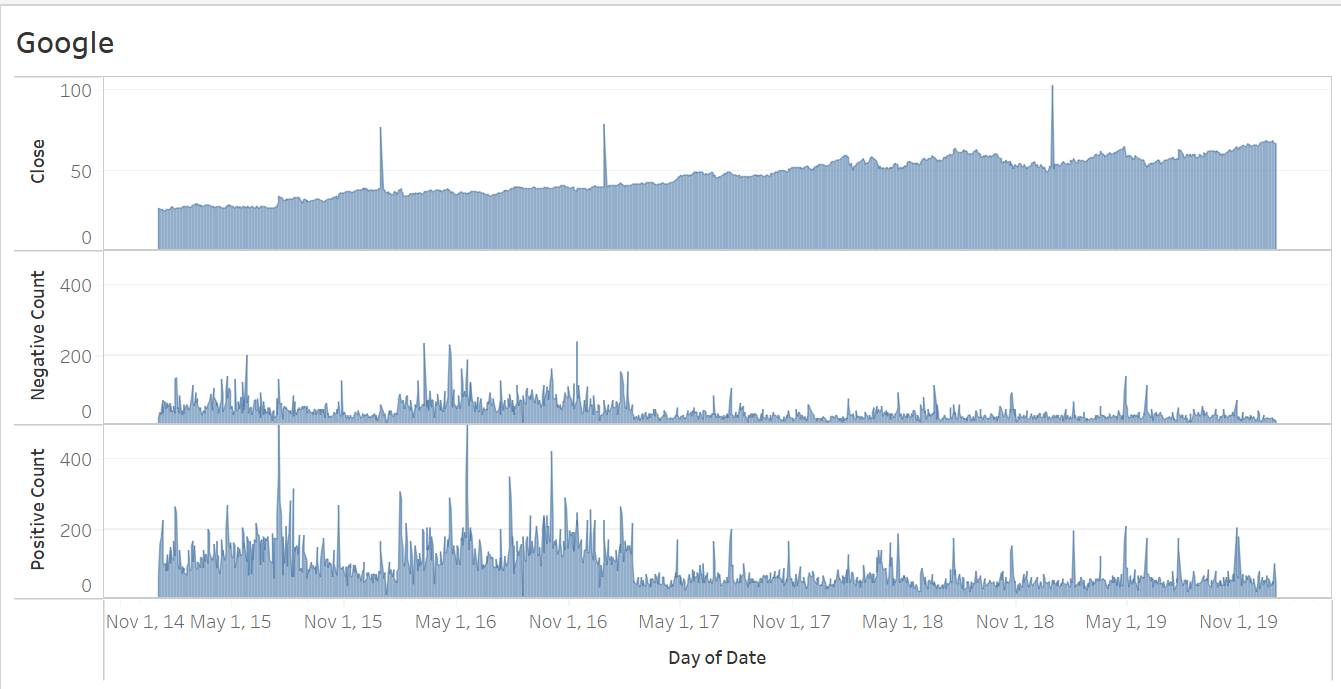

In [152]:
sdf_goog = spark.createDataFrame(df3_goog)

In [153]:
sdf_goog.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|
+-------------------+--------------+-------------+--------------+-----+----------+
|2015-01-05 00:00:00|          34.0|        108.0|         156.0|25.62|     26.17|
|2015-01-06 00:00:00|          24.0|        158.0|         178.0|25.03|     25.62|
|2015-01-07 00:00:00|          45.0|        144.0|         181.0|24.99|     25.03|
|2015-01-08 00:00:00|          67.0|        224.0|         223.0|25.07|     24.99|
|2015-01-09 00:00:00|          30.0|        174.0|         104.0|24.74|     25.07|
+-------------------+--------------+-------------+--------------+-----+----------+
only showing top 5 rows



In [154]:
# Import required modules
from pyspark.ml.feature import VectorAssembler

# Define the feature column names
feature_cols = ['negative_count','neutral_count','positive_count','prev_close']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform the data using the VectorAssembler
data_goog = assembler.transform(sdf_goog)
data_goog = data_goog.na.drop()

# Split the data into training and test sets
train_data_goog = data_goog.limit(int(0.80 * data_goog.count()))
test_data_goog = data_goog.subtract(train_data_goog)


In [155]:
from pyspark.ml.feature import StandardScaler

# Define the scaler and fit it on the training data
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(train_data_goog)

# Apply the scaler on both training and test data
train_data_goog = scaler_model.transform(train_data_goog)
test_data_goog= scaler_model.transform(test_data_goog)


In [156]:
train_data_goog.show(5)

+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|               date|negative_count|neutral_count|positive_count|Close|prev_close|            features|     scaled_features|
+-------------------+--------------+-------------+--------------+-----+----------+--------------------+--------------------+
|2015-01-05 00:00:00|          34.0|        108.0|         156.0|25.62|     26.17|[34.0,108.0,156.0...|[-0.2442178184129...|
|2015-01-06 00:00:00|          24.0|        158.0|         178.0|25.03|     25.62|[24.0,158.0,178.0...|[-0.5787354987502...|
|2015-01-07 00:00:00|          45.0|        144.0|         181.0|24.99|     25.03|[45.0,144.0,181.0...|[0.12375162995813...|
|2015-01-08 00:00:00|          67.0|        224.0|         223.0|25.07|     24.99|[67.0,224.0,223.0...|[0.85969052670028...|
|2015-01-09 00:00:00|          30.0|        174.0|         104.0|24.74|     25.07|[30.0,174.0,104.0...|[-0.3780248905478...|


In [157]:
# Import required modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

# Train linear regression model on the training data
lr = LinearRegression(featuresCol='scaled_features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data_goog)

# Train decision tree regression model on the training data
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='Close', maxDepth=5, minInstancesPerNode=20)
dt_model = dt.fit(train_data_goog)

# Train gradient boosted tree regression model on the training data
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='Close', maxIter=10, maxDepth=5, minInstancesPerNode=20)
gbt_model = gbt.fit(train_data_goog)

# Make predictions on the train data using all models
train_lr_predictions_goog = lr_model.transform(train_data_goog)
train_dt_predictions_goog = dt_model.transform(train_data_goog)
train_gbt_predictions_goog = gbt_model.transform(train_data_goog)

# Make predictions on the test data using all models
test_lr_predictions_goog = lr_model.transform(test_data_goog)
test_dt_predictions_goog = dt_model.transform(test_data_goog)
test_gbt_predictions_goog = gbt_model.transform(test_data_goog)

# Evaluate the models using both RMSE and R2 metrics
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
r2_evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

train_lr_rmse_goog = rmse_evaluator.evaluate(train_lr_predictions_goog)
train_dt_rmse_goog = rmse_evaluator.evaluate(train_dt_predictions_goog)
train_gbt_rmse_goog = rmse_evaluator.evaluate(train_gbt_predictions_goog)

test_lr_rmse_goog = rmse_evaluator.evaluate(test_lr_predictions_goog)
test_dt_rmse_goog = rmse_evaluator.evaluate(test_dt_predictions_goog)
test_gbt_rmse_goog = rmse_evaluator.evaluate(test_gbt_predictions_goog)

train_lr_r2_goog = r2_evaluator.evaluate(train_lr_predictions_goog)
train_dt_r2_goog = r2_evaluator.evaluate(train_dt_predictions_goog)
train_gbt_r2_goog = r2_evaluator.evaluate(train_gbt_predictions_goog)

test_lr_r2_goog = r2_evaluator.evaluate(test_lr_predictions_goog)
test_dt_r2_goog = r2_evaluator.evaluate(test_dt_predictions_goog)
test_gbt_r2_goog = r2_evaluator.evaluate(test_gbt_predictions_goog)

# Print the train RMSE and R2 scores for all models
print("Linear Regression train rmse score: ", train_lr_rmse_goog)
print("Linear Regression train r2 score: ", train_lr_r2_goog)

print("Decision Tree Regression train rmse score:", train_dt_rmse_goog)
print("Decision Tree Regression train r2 score:", train_dt_r2_goog)

print("Gradient Boosted Tree Regression train rmse score", train_gbt_rmse_goog)
print("Gradient Boosted Tree Regression train r2 score", train_gbt_r2_goog)

# Print the test RMSE and R2 scores for all models
print("Linear Regression test rmse score: ", test_lr_rmse_goog)
print("Linear Regression test r2 score: ", test_lr_r2_goog)

print("Decision Tree Regression test rmse score:", test_dt_rmse_goog)
print("Decision Tree Regression test r2 score:", test_dt_r2_goog)

print("Gradient Boosted Tree Regression test rmse score", test_gbt_rmse_goog)
print("Gradient Boosted Tree Regression test r2 score", test_gbt_r2_goog)


Linear Regression train rmse score:  0.7075758993949217
Linear Regression train r2 score:  0.9951351506978419
Decision Tree Regression train rmse score: 0.8142164120145065
Decision Tree Regression train r2 score: 0.9935582623747606
Gradient Boosted Tree Regression train rmse score 0.7647020486306539
Gradient Boosted Tree Regression train r2 score 0.9943179135773776
Linear Regression test rmse score:  1.0502203415865632
Linear Regression test r2 score:  0.9343690412757508
Decision Tree Regression test rmse score: 2.21998460822302
Decision Tree Regression test r2 score: 0.706743380818305
Gradient Boosted Tree Regression test rmse score 2.1936340675296795
Gradient Boosted Tree Regression test r2 score 0.7136637973736185


In [158]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Random Forest regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross-validation object
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=r2_evaluator, numFolds=5)

# Train the model on the training data using cross-validation
cv_model = cv.fit(train_data_goog)

# Make predictions on the test and train data
test_rf_predictions_goog = cv_model.transform(test_data_goog)
train_rf_predictions_goog = cv_model.transform(train_data_goog)

# Evaluate the model performance using the train r2 score and rmse
train_rf_r2_goog = r2_evaluator.evaluate(train_rf_predictions_goog)
train_rf_rmse_goog = rmse_evaluator.evaluate(train_rf_predictions_goog)

# Evaluate the model performance using the test r2 score and rmse
test_rf_r2_goog = r2_evaluator.evaluate(test_rf_predictions_goog)
test_rf_rmse_goog = rmse_evaluator.evaluate(test_rf_predictions_goog)

print("Random Forest Regression train rmse score", train_rf_rmse_goog)
print("Random Forest Regression train r2 score", train_rf_r2_goog)

print("Random Forest Regression test rmse score", test_rf_rmse_goog)
print("Random Forest Regression test r2 score", test_rf_r2_goog)

Random Forest Regression train rmse score 0.3907017229701044
Random Forest Regression train r2 score 0.9985167512860081
Random Forest Regression test rmse score 2.7696835959730075
Random Forest Regression test r2 score 0.5435342313853804


In [159]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the L1 regularized Linear Regression model (Lasso)
lr_l1 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=1, solver='normal')

# Train the L1 regularized Linear Regression model on the training data
lr_l1_model = lr_l1.fit(train_data_goog)

# Make predictions on the test data using the L1 regularized model
train_predictions_l1_goog = lr_l1_model.transform(test_data_goog)
test_predictions_l1_goog = lr_l1_model.transform(test_data_goog)

# Evaluate the performance of the L1 regularized model using the r2 score
train_r2_l1_goog = r2_evaluator.evaluate(train_predictions_l1_goog)
train_rmse_l1_goog = rmse_evaluator.evaluate(train_predictions_l1_goog)
print('L1 Regularized Linear Regression train r2:', train_r2_l1_goog)
print('L1 Regularized Linear Regression train rmse:', train_rmse_l1_goog)

test_r2_l1_goog = r2_evaluator.evaluate(test_predictions_l1_goog)
test_rmse_l1_goog = rmse_evaluator.evaluate(test_predictions_l1_goog)
print('L1 Regularized Linear Regression test r2:', test_r2_l1_goog)
print('L1 Regularized Linear Regression test rmse:', test_rmse_l1_goog)

# Define the L2 regularized Linear Regression model (Ridge)
lr_l2 = LinearRegression(featuresCol='features', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0, solver='normal')

# Train the L2 regularized Linear Regression model on the training data
lr_l2_model = lr_l2.fit(train_data_goog)

# Make predictions on the test data using the L2 regularized model
train_predictions_l2_goog = lr_l2_model.transform(train_data_goog)
test_predictions_l2_goog = lr_l2_model.transform(test_data_goog)

# Evaluate the performance of the L2 regularized model using the r2 score
train_r2_l2_goog = r2_evaluator.evaluate(train_predictions_l2_goog)
train_rmse_l2_goog = rmse_evaluator.evaluate(train_predictions_l2_goog)
print('L2 Regularized Linear Regression train r2:', train_r2_l2_goog)
print('L2 Regularized Linear Regression train rmse:', train_rmse_l2_goog)

test_r2_l2_goog = r2_evaluator.evaluate(test_predictions_l2_goog)
test_rmse_l2_goog = rmse_evaluator.evaluate(test_predictions_l2_goog)
print('L2 Regularized Linear Regression test r2:', test_r2_l2_goog)
print('L2 Regularized Linear Regression test rmse:', test_rmse_l2_goog)


L1 Regularized Linear Regression train r2: 0.9340854467526429
L1 Regularized Linear Regression train rmse: 1.0524869219798973
L1 Regularized Linear Regression test r2: 0.9340854467526429
L1 Regularized Linear Regression test rmse: 1.0524869219798973
L2 Regularized Linear Regression train r2: 0.9948526506901533
L2 Regularized Linear Regression train rmse: 0.7278303424618953
L2 Regularized Linear Regression test r2: 0.9341031783436955
L2 Regularized Linear Regression test rmse: 1.052345348366663


In [160]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Train an XGBoost Regressor
xgb = SparkXGBRegressor(features_col='features', label_col='Close')
evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

# Fit the model
model = xgb.fit(train_data_goog)

# Make predictions on the test and train data
train_predictions_xgb_goog = model.transform(train_data_goog)
test_predictions_xgb_goog = model.transform(test_data_goog)

train_r2_xgb_goog = r2_evaluator.evaluate(train_predictions_xgb_goog)
train_rmse_xgb_goog = rmse_evaluator.evaluate(train_predictions_xgb_goog)
print('xgb Regressor train r2:', train_r2_xgb_goog)
print('xgb Regressor train rmse:', train_rmse_xgb_goog)

test_r2_xgb_goog = r2_evaluator.evaluate(test_predictions_xgb_goog)
test_rmse_xgb_goog = rmse_evaluator.evaluate(test_predictions_xgb_goog)
print('xgb Regressor test r2:', test_r2_xgb_goog)
print('xgb Regressor test rmse:', test_rmse_xgb_goog)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgb Regressor train r2: 0.9998897266924701
xgb Regressor train rmse: 0.10653039484364897
xgb Regressor test r2: 0.7667972388445928
xgb Regressor test rmse: 1.979670428170727
